**Author:** "Nicholas Sager"

In [1]:
knitr::opts_chunk$set(echo = FALSE)
knitr::opts_chunk$set(warning=FALSE) # Hide warnings, use for final version.
knitr::opts_chunk$set(message=FALSE) # Hide messages, use for final version.

# Required Libraries
library(knitr)
library(kableExtra)
library(ggthemes)
library(multcomp)
library(caret)
library(janitor)
library(doParallel)
library(e1071)
library(class)
library(tidyverse)

Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumula

## Introduction

DDSAnalytics is an analytics company that specializes in talent management solutions for Fortune 100 companies. Talent management is defined as the iterative process of developing and retaining employees. It may include workforce planning, employee training programs, identifying high-potential employees and reducing/preventing voluntary employee turnover (attrition). To gain a competitive edge over its competition, DDSAnalytics is planning to leverage data science for talent management. The executive leadership has identified predicting employee turnover as its first application of data science for talent management. Before the business green lights the project, they have tasked our data science team to conduct an analysis of existing employee data. 

Given a dataset, we will do a data analysis to identify factors that lead to attrition.  We will identify the top three factors that contribute to turnover (backed up by evidence provided by analysis). There may or may not be a need to create derived attributes/variables/features. The business is also interested in learning about any job role specific trends that may exist in the data set (e.g., “Data Scientists have the highest job satisfaction”). We will also provide any other interesting trends and observations from our analysis. The analysis will be backed up by robust experimentation and appropriate visualization. Experiments and analysis will be conducted in R. We will also to build a model to predict attrition.  Finally, we will develop an RShiny App to visualize some of the relationships or lack thereof.

For an interactive app to visualize this data, please see: [Shiny App](https://nicksager.shinyapps.io/CaseStudy2/)

For a video presentation of this analysis, please see: [Video Presentation](https://youtu.be/s0PUkwGvoew)

## Data Description

The dataset is a collection of existing employee data provided by DDSAnalytics, which advises primarily Fortune 100 companies. It contains 870 records of 31 variables for each employee. Variables measured include, but are not limited to, job title and department, salary information, satisfaction with various aspects, and whether or not the employee left. We additionally have testing datasets which have Attrition or Salary information withheld which will be used to evaluate the models.

In [2]:
#Read the Data and look at the first few rows
df = read_csv("CaseStudy2-data.csv", show_col_types = FALSE)

head(df)
str(df)

ID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,32,No,Travel_Rarely,117,Sales,13,4,Life Sciences,1,⋯,3,80,1,8,3,2,5,2,0,3
2,40,No,Travel_Rarely,1308,Research & Development,14,3,Medical,1,⋯,1,80,0,21,2,4,20,7,4,9
3,35,No,Travel_Frequently,200,Research & Development,18,2,Life Sciences,1,⋯,3,80,0,10,2,3,2,2,2,2
4,32,No,Travel_Rarely,801,Sales,1,4,Marketing,1,⋯,3,80,2,14,3,3,14,10,5,7
5,24,No,Travel_Frequently,567,Research & Development,2,1,Technical Degree,1,⋯,3,80,0,6,2,3,6,3,1,3
6,27,No,Travel_Frequently,294,Research & Development,10,2,Life Sciences,1,⋯,3,80,2,9,4,2,9,7,1,7


spc_tbl_ [870 × 36] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ID                      : num [1:870] 1 2 3 4 5 6 7 8 9 10 ...
 $ Age                     : num [1:870] 32 40 35 32 24 27 41 37 34 34 ...
 $ Attrition               : chr [1:870] "No" "No" "No" "No" ...
 $ BusinessTravel          : chr [1:870] "Travel_Rarely" "Travel_Rarely" "Travel_Frequently" "Travel_Rarely" ...
 $ DailyRate               : num [1:870] 117 1308 200 801 567 ...
 $ Department              : chr [1:870] "Sales" "Research & Development" "Research & Development" "Sales" ...
 $ DistanceFromHome        : num [1:870] 13 14 18 1 2 10 5 10 10 10 ...
 $ Education               : num [1:870] 4 3 2 4 1 2 5 4 4 4 ...
 $ EducationField          : chr [1:870] "Life Sciences" "Medical" "Life Sciences" "Marketing" ...
 $ EmployeeCount           : num [1:870] 1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeNumber          : num [1:870] 859 1128 1412 2016 1646 ...
 $ EnvironmentSatisfaction : num [1:870] 2 3 3 3 1 4 2 4 3 4 ...
 $ Gender

## Data Exploration

### NA Values

The first thing we will look for in the data is whether there are any NA values, and if so, where they are. If present, NAs will have to be handled in some way before we can proceed with our analysis.

In [3]:
# Summarise na's by column
df %>%
    summarize_all(~ sum(is.na(.))) %>%
    data.frame()

ID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Number of distinct values per column:

In [4]:
# Summarise dinstinct values by column
df %>%
    summarize_all(~ n_distinct(.)) %>%
    data.frame()

ID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
870,43,2,3,627,3,29,5,6,1,⋯,4,1,4,39,7,4,32,19,16,17


There are no NA values in the data set. There are, however, three columns with only one unique value: Over18, StandardHours, and EmployeeCount. We will remove these columns from the data set so that they do not interfere with our analysis.

In [5]:
# Remove columns with only one unique value
df <- df %>%
    select(-c(Over18, StandardHours, EmployeeCount))

### Visualizing Variables of interest

The two variables we are most concerned about are Salary (MonthlyIncome) and Attrition. We will start by visualizing these variables.

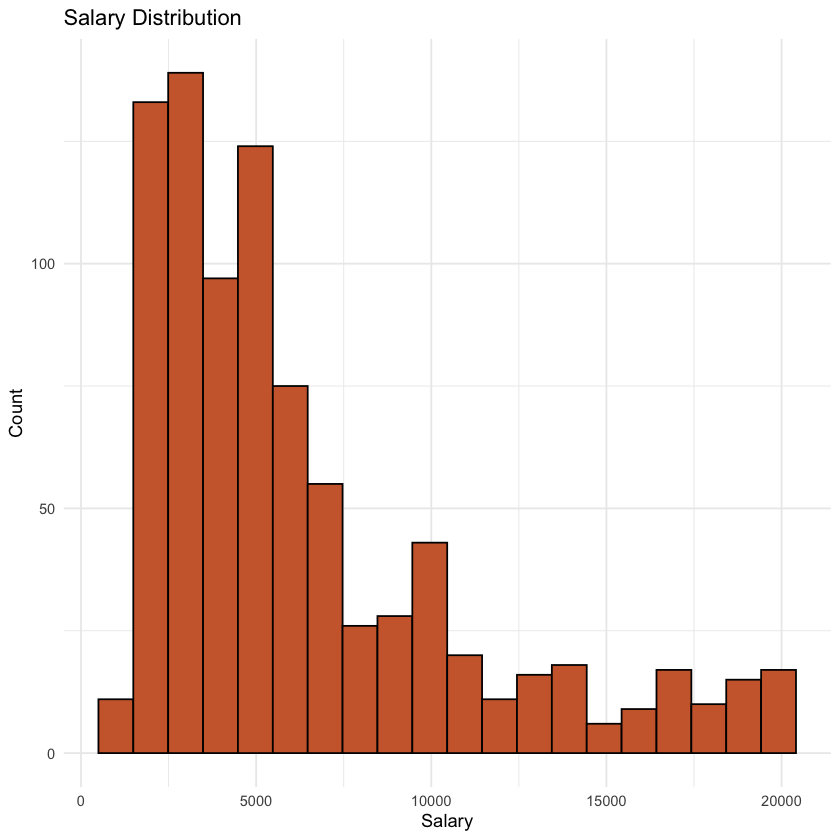

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1081    2840    4946    6390    8182   19999 

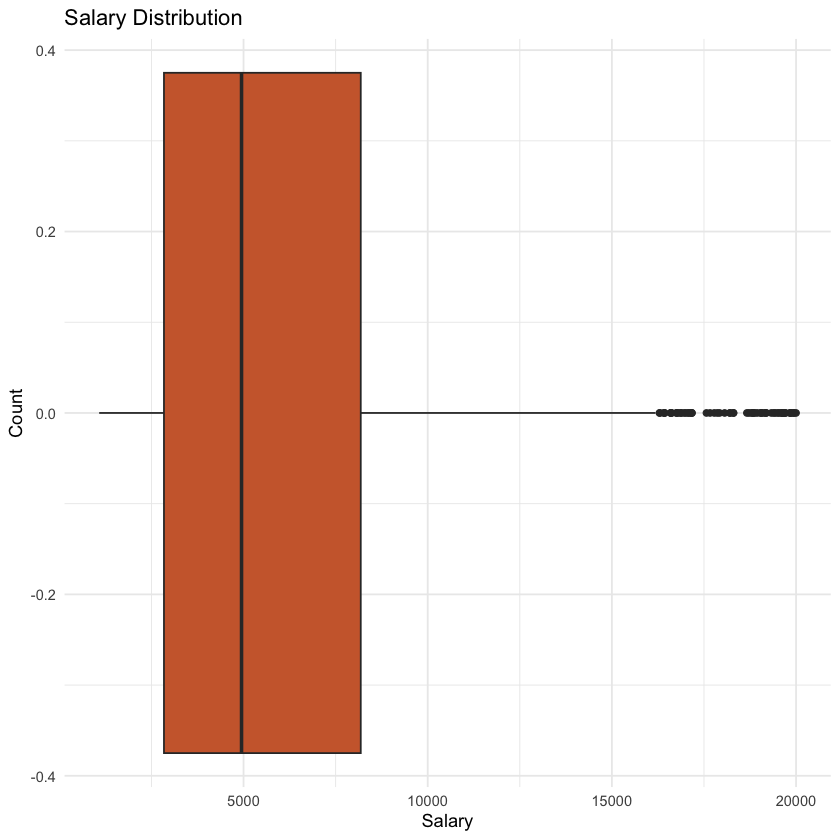

In [6]:
# Salary Exploration
df %>%
    ggplot(aes(x = MonthlyIncome)) +
    geom_histogram(bins = 20, fill = "sienna3", color = "black") +
    theme_minimal() +
    labs(
        title = "Salary Distribution",
        x = "Salary",
        y = "Count"
    )

df %>%
    ggplot(aes(x = MonthlyIncome)) +
    geom_boxplot(fill = "sienna3") +
    theme_minimal() +
    labs(
        title = "Salary Distribution",
        x = "Salary",
        y = "Count"
    )

summary(df$MonthlyIncome)

There is some evidence of right skew in the salary data. The median monthly salary is $4946 and the mean is $6390, which supports the right skew. We will most likely use a log transformation for our analysis of salary.

Next we will explore the overall attrition rate in the data set:

No Yes 
730 140

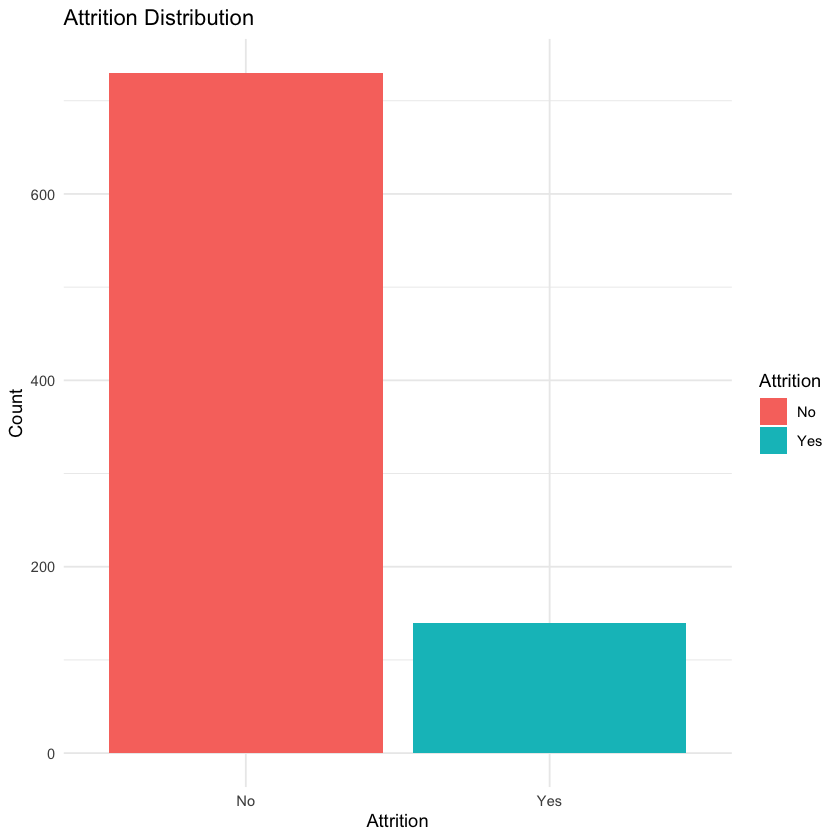

In [7]:
# Attrition Exploration
df %>%
    ggplot(aes(x = Attrition, fill = Attrition)) +
    geom_bar() +
    theme_minimal() +
    labs(
        title = "Attrition Distribution",
        x = "Attrition",
        y = "Count"
    )

summary(as.factor(df$Attrition))

We can see that the dataset is quite unbalanced in regards to attrition. There are 730 employees who have not left the company, and only 140 who have left (19%). This will be important to keep in mind when we are building our models and may necessitate the use of resampling techniques.

Let's visualize whether salary and attrition are related to each other:


	Welch Two Sample t-test

data:  df %>% filter(Attrition == "Yes") %>% pull(MonthlyIncome) and df %>% filter(Attrition == "No") %>% pull(MonthlyIncome)
t = -5.3249, df = 228.45, p-value = 2.412e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2654.047 -1220.382
sample estimates:
mean of x mean of y 
 4764.786  6702.000 


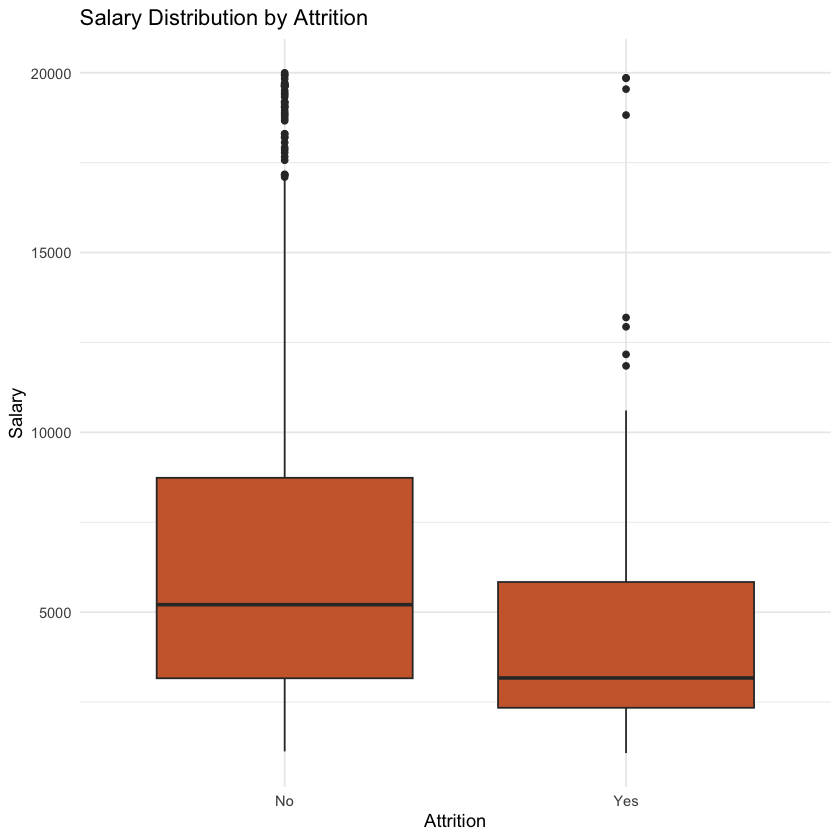

In [8]:
# Salary vs Attrition
df %>%
    ggplot(aes(x = Attrition, y = MonthlyIncome)) +
    geom_boxplot(fill = "sienna3") +
    theme_minimal() +
    labs(
        title = "Salary Distribution by Attrition",
        x = "Attrition",
        y = "Salary"
    )

# Test whether salary is different between groups
t.test(
    df %>%
        filter(Attrition == "Yes") %>%
        pull(MonthlyIncome),
    df %>%
        filter(Attrition == "No") %>%
        pull(MonthlyIncome)
)

It appears that lower salaries are associated with attrition. We will explore this relationship further in our analysis, but salary will likely be an important factor in our model. The mean salaries of those who left the company are significantly lower than those who stayed (p < 0.001 for a Welch's two sample t-test). We can be 95% confident that the mean monthly salary is between $1220 and $2650 lower for those who left. Our best estimate is $1937 lower. 

### Salary and Attrition by other Metrics
First we will look at salary by department:

Department,mean_salary,median_salary,sd_salary
<chr>,<dbl>,<dbl>,<dbl>
Sales,6788.780,5673.0,3891.396
Research & Development,6172.648,4445.5,4747.424
Human Resources,6776.143,2942.0,6711.971


             Df    Sum Sq  Mean Sq F value Pr(>F)
Department    2 7.518e+07 37591343   1.782  0.169
Residuals   867 1.829e+10 21100855               

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = MonthlyIncome ~ Department, data = df)

$Department
                                             diff        lwr      upr     p adj
Research & Development-Human Resources -603.49517 -2482.3144 1275.324 0.7312142
Sales-Human Resources                    12.63736 -1923.6064 1948.881 0.9998706
Sales-Research & Development            616.13253  -179.4656 1411.731 0.1642162



	Kruskal-Wallis rank sum test

data:  MonthlyIncome by Department
Kruskal-Wallis chi-squared = 25.546, df = 2, p-value = 2.836e-06


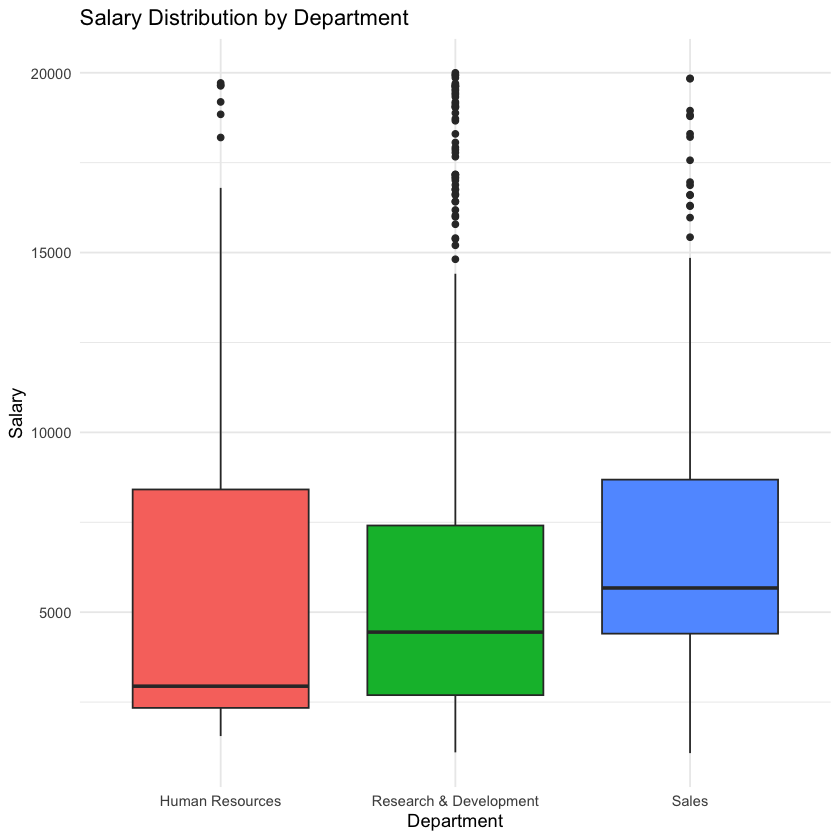

In [9]:
# Salary by Department boxplots
df %>%
    ggplot(aes(x = Department, y = MonthlyIncome, fill = Department)) +
    geom_boxplot(show.legend = FALSE) +
    theme_minimal() +
    labs(
        title = "Salary Distribution by Department",
        x = "Department",
        y = "Salary"
    )


df %>%
    group_by(Department) %>%
    summarize(
        mean_salary = mean(MonthlyIncome),
        median_salary = median(MonthlyIncome),
        sd_salary = sd(MonthlyIncome)
    ) %>%
    arrange(desc(median_salary)) # %>%
    # kable() %>%
    # kable_styling()

# Test whether mean salaries are different using a multiple comparison test
model <- aov(MonthlyIncome ~ Department, data = df)
summary(model)
TukeyHSD(model)

# Test whether median salaries are different using a multiple comparison test
kruskal.test(
    MonthlyIncome ~ Department,
    data = df
)

Sales vs. Research & Development:

In [10]:
# How to do multiple comparisons of the median??
# wilcoxon rank sum test
wilcox.test(MonthlyIncome ~ Department,
    data = df[(df$Department == "Sales" | df$Department == "Research & Development"), ],
    paired = FALSE, alternative = "two.sided"
)


	Wilcoxon rank sum test with continuity correction

data:  MonthlyIncome by Department
W = 61061, p-value = 1.69e-06
alternative hypothesis: true location shift is not equal to 0


Sales vs. Human Resources:

In [11]:
wilcox.test(MonthlyIncome ~ Department,
    data = df[(df$Department == "Sales" | df$Department == "Human Resources"), ],
    paired = FALSE, alternative = "two.sided"
)


	Wilcoxon rank sum test with continuity correction

data:  MonthlyIncome by Department
W = 3414.5, p-value = 0.006017
alternative hypothesis: true location shift is not equal to 0


Human Resources vs. Research & Development:

In [12]:
wilcox.test(MonthlyIncome ~ Department,
    data = df[(df$Department == "Human Resources" | df$Department == "Research & Development"), ],
    paired = FALSE, alternative = "two.sided"
)


	Wilcoxon rank sum test with continuity correction

data:  MonthlyIncome by Department
W = 8706.5, p-value = 0.2546
alternative hypothesis: true location shift is not equal to 0


The departments have similar mean salaries, but the median salaries vary greatly. The highest median salary is in the Sales department and the lowest is in Human Resources. We will keep this in mind when exploring attrition. Additionally, the right skew is present across all of the departments but is extremely pronounced in the Human Resources department. 

Looking at the Human Resources department, there are only two roles. Managers who are paid among the highest salaries and "Human Resources" who are paid among the lowest. This may be worth investigating further if time and resources permit, but the skew is most likely related to the lack of a mid-level role in the Human Resources department.

The mean salaries are not significantly different between the departments (p = 0.16 from an ANOVA), but the median salaries are (p < 0.001 from a Kruskal-Wallis test). The median salaries are significantly different between the Sales and Human Resources departments (p = 0.006 from a Wilcoxon rank sum test), and between the Sales and Research & Development departments (p < 0.001 from a Wilcoxon rank sum test). The median salaries are not significantly different between the Human Resources and Research & Development departments (p = 0.25 from a Wilcoxon rank sum test).

Next, let's look at salary by Job Role:

JobRole,mean_salary,median_salary,sd_salary
<chr>,<dbl>,<dbl>,<dbl>
Manager,17197.157,17174.0,2287.3748
Research Director,15749.902,16184.0,2868.0253
Healthcare Representative,7435.342,6796.0,2455.7048
Manufacturing Director,7505.218,6499.0,2719.7007
Sales Executive,6891.780,6222.0,2352.8840
Laboratory Technician,3221.856,2867.0,1184.8630
Research Scientist,3259.331,2774.5,1290.9816
Human Resources,3284.630,2742.0,1751.7089
Sales Representative,2652.830,2610.0,880.3272


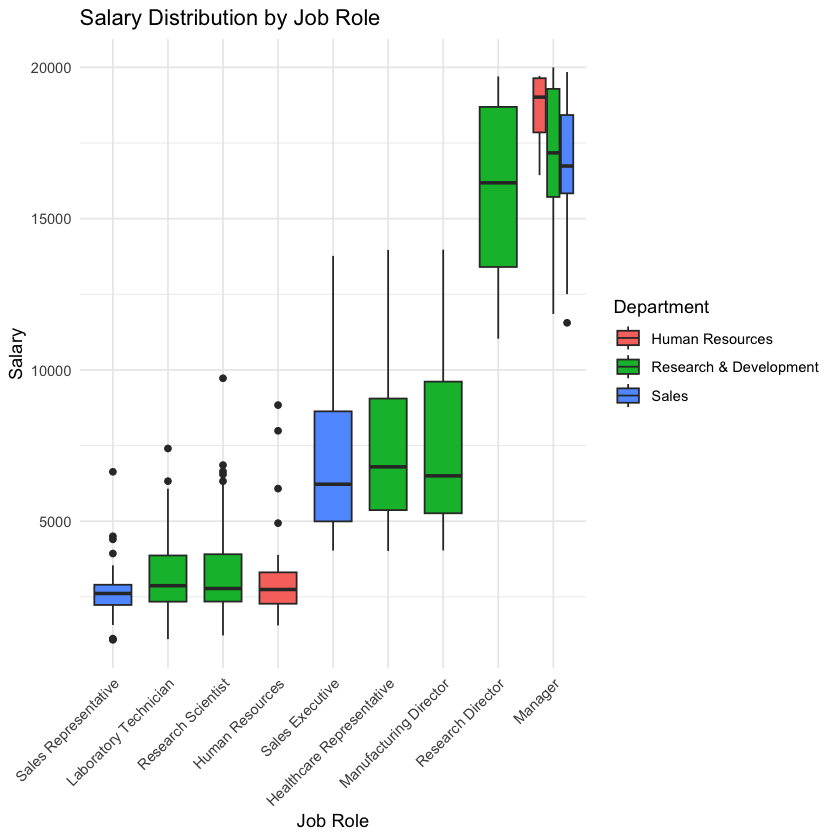

In [13]:
# Salary by JobRole boxplots
df %>%
    ggplot(aes(x = reorder(JobRole, MonthlyIncome), y = MonthlyIncome, fill = Department)) +
    geom_boxplot() +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(
        title = "Salary Distribution by Job Role",
        x = "Job Role",
        y = "Salary"
    )

df %>%
    group_by(JobRole) %>%
    summarize(
        mean_salary = mean(MonthlyIncome),
        median_salary = median(MonthlyIncome),
        sd_salary = sd(MonthlyIncome)
    ) %>%
    arrange(desc(median_salary)) # %>%
    # kable() %>%
    # kable_styling()


There are three distinct tiers here. Managers and Research directors make the most, followed by Healthcare Representatives, Manufacturing Directors, and Sales Executives. The remaining roles fill a lower tier of salaries.

Next we will repeat the same analysis for attrition. First, by department:

Department,attrition_rate,sd_attrition
<chr>,<dbl>,<dbl>
Sales,0.2161172,0.4123511
Human Resources,0.1714286,0.3823853
Research & Development,0.1334520,0.3403655


             Df Sum Sq Mean Sq F value  Pr(>F)   
Department    2   1.26  0.6298   4.699 0.00934 **
Residuals   867 116.21  0.1340                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Attrition == "Yes" ~ Department, data = df)

$Department
                                              diff         lwr       upr
Research & Development-Human Resources -0.03797661 -0.18772088 0.1117676
Sales-Human Resources                   0.04468864 -0.10963242 0.1990097
Sales-Research & Development            0.08266526  0.01925508 0.1460754
                                           p adj
Research & Development-Human Resources 0.8226181
Sales-Human Resources                  0.7752965
Sales-Research & Development           0.0064350


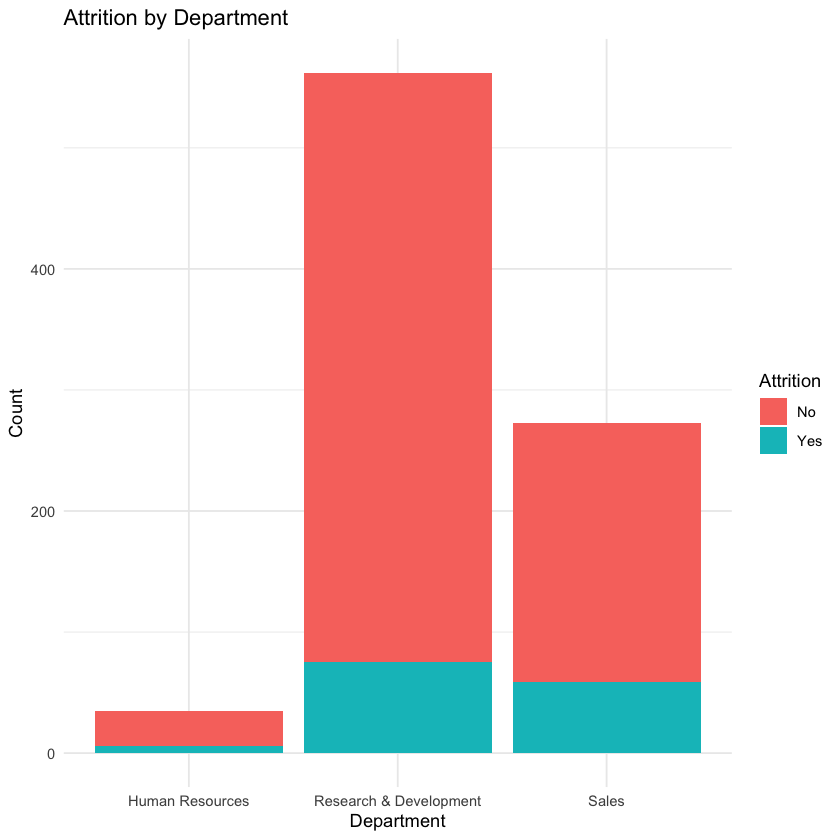

In [14]:
# Attrition by Department plot
df %>%
    group_by(Department) %>%
    ggplot(aes(x = (Department), fill = Attrition)) +
    geom_bar() +
    theme_minimal() +
    labs(
        title = "Attrition by Department",
        x = "Department",
        y = "Count"
    )

df %>%
    group_by(Department) %>%
    summarize(
        attrition_rate = mean(Attrition == "Yes"),
        sd_attrition = sd(Attrition == "Yes")
    ) %>%
    arrange(desc(attrition_rate)) # %>%
        # kable() %>%
        # kable_styling()
    
# Test whether attrition rates are different using a multiple comparison test
model <- aov(Attrition == "Yes" ~ Department, data = df)
summary(model)
TukeyHSD(model)

Sales has the highest attrition while Research & Development has the lowest. The difference in attrition rate between the Sales and R & D departments is significant (p < 0.01 from a Tukey HSD test).

Here is the Attrition by JobRole:

JobRole,attrition_rate,sd_attrition
<chr>,<dbl>,<dbl>
Sales Representative,0.45283019,0.5025335
Human Resources,0.22222222,0.4236593
Laboratory Technician,0.19607843,0.3983324
Research Scientist,0.18604651,0.3902804
Sales Executive,0.16500000,0.3721120
Healthcare Representative,0.10526316,0.3089314
Manager,0.07843137,0.2715244
Manufacturing Director,0.02298851,0.1507355
Research Director,0.01960784,0.1400280


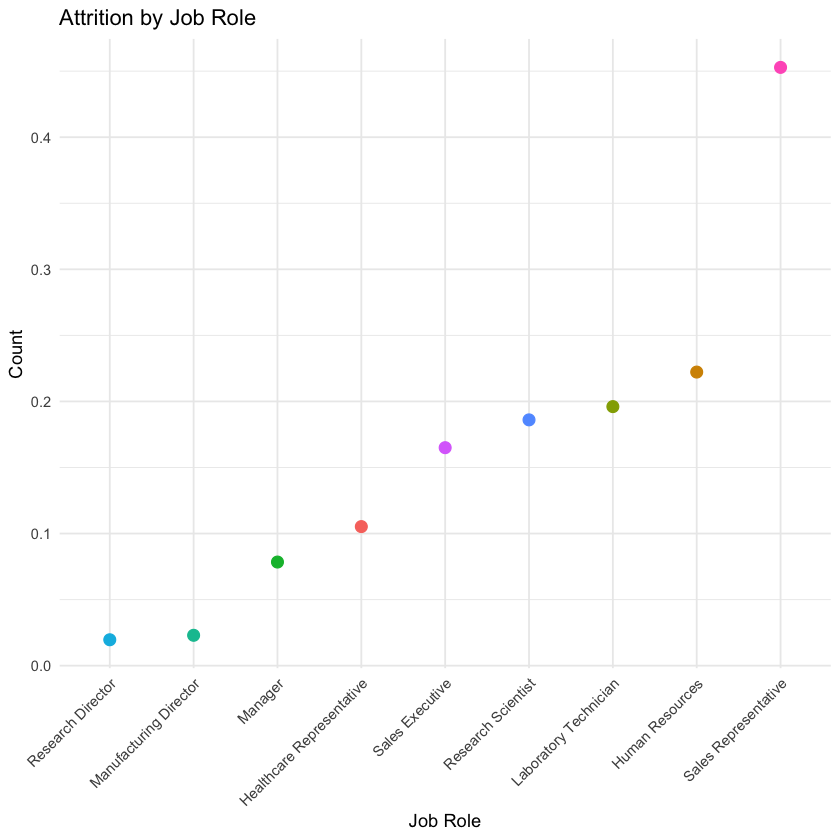

In [15]:
# Attrition by JobRole scatterplot
df %>%
    group_by(JobRole) %>%
    summarize(
        attrition_rate = mean(Attrition == "Yes"),
        sd_attrition = sd(Attrition == "Yes")
    ) %>%
    ggplot(aes(x = reorder(JobRole, attrition_rate), y = attrition_rate, color = JobRole)) +
        geom_point(size = 3, show.legend = FALSE) +
        theme_minimal() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(
            title = "Attrition by Job Role",
            x = "Job Role",
            y = "Count"
        )

df %>%
    group_by(JobRole) %>%
    summarize(
        attrition_rate = mean(Attrition == "Yes"),
        sd_attrition = sd(Attrition == "Yes")
    ) %>%
    arrange(desc(attrition_rate)) # %>%
    # kable() %>%
    # kable_styling()

The attrition rate is highest for Sales Representatives by more than double the next highest. This is an interesting finding and will be explored further in our analysis. Also noteworthy is that the hightest paying tier of roles has the lowest attrition rates.

Next we will explore several relationships that may be of interest in understanding attrition. First, we will look at the relationship between median salary and attrition of a role.

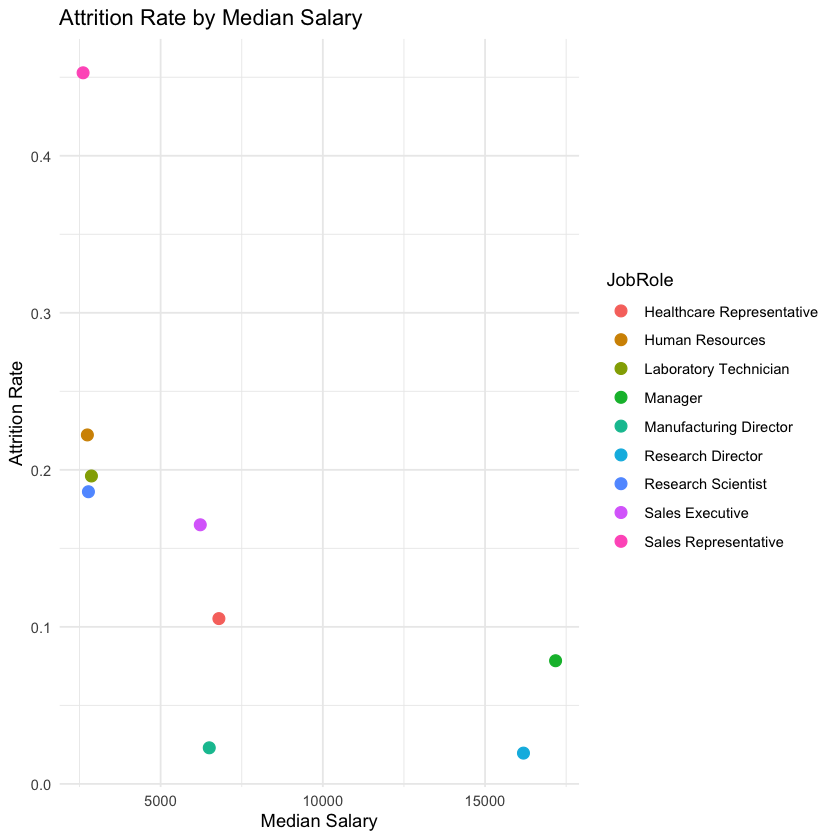

In [16]:
# Attrition Rate by Median Salary grouped by JobRole
df %>%
    group_by(JobRole) %>%
    summarize(
        median_salary = median(MonthlyIncome),
        attrition_rate = mean(Attrition == "Yes")
    ) %>%
    ggplot(aes(x = (median_salary), y = (attrition_rate), color = JobRole)) +
    geom_point(size = 3) +
    theme_minimal() +
    labs(
        title = "Attrition Rate by Median Salary",
        x = "Median Salary",
        y = "Attrition Rate"
    )

There appears to be a negative relationship between Attrition rate and Median Salary. Sales Representatives appear to be an exception to this trend and probably have other factors that are driving their high attrition rate. Similarly, Manufacturing directors have a much lower attrition than their salary may suggest. 

For good measure, we will count the number of each role in the dataset in order to check whether small sample sizes may be skewing our results.

In [17]:
# Count of each JobRole
df %>%
    group_by(JobRole) %>%
    summarize(
        count = n()
    ) %>%
    arrange(desc(count)) # %>%
    # kable() %>%
    # kable_styling()

JobRole,count
<chr>,<int>
Sales Executive,200
Research Scientist,172
Laboratory Technician,153
Manufacturing Director,87
Healthcare Representative,76
Sales Representative,53
Manager,51
Research Director,51
Human Resources,27


The sample sizes are large enough that we can assume the Central Limit Theorem and be confident that the results are not due to small sample sizes alone. As one would expect, there are less of the highest tier of jobs.

Next, we will investigate the relationship between the mean Job Satisfaction and Attrition rate by role.

JobRole,mean_satisfaction,attrition_rate
<chr>,<dbl>,<dbl>
Healthcare Representative,2.828947,0.10526316
Human Resources,2.555556,0.22222222
Laboratory Technician,2.686275,0.19607843
Manager,2.509804,0.07843137
Manufacturing Director,2.724138,0.02298851
Research Director,2.490196,0.01960784
Research Scientist,2.802326,0.18604651
Sales Executive,2.725000,0.16500000
Sales Representative,2.698113,0.45283019


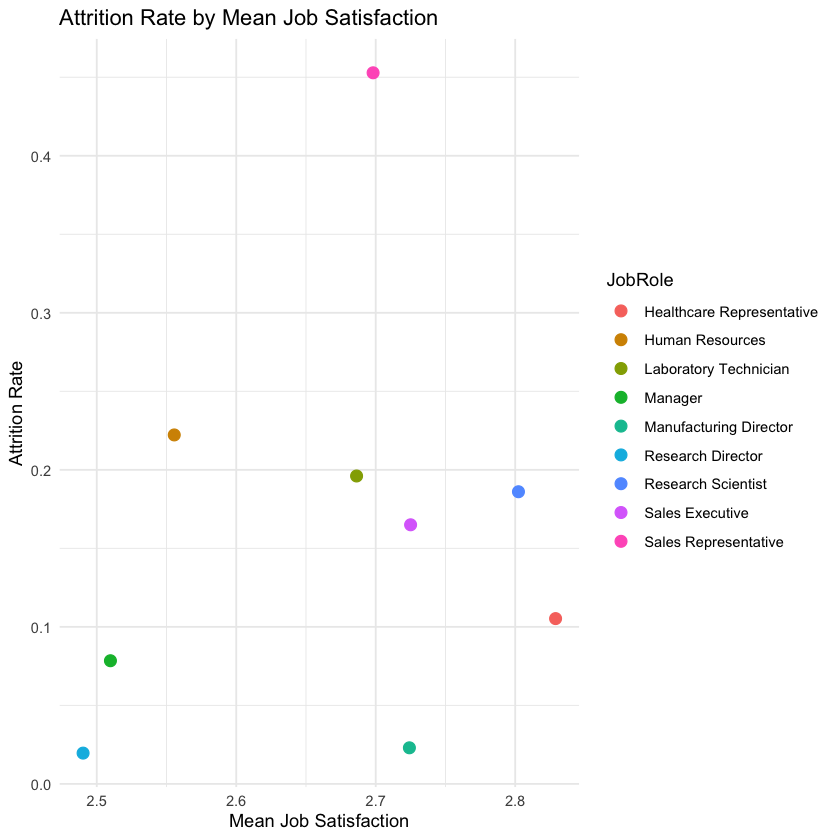

In [18]:
# Attrition Rate by Mean Job Satisfaction grouped by JobRole
df %>%
    group_by(JobRole) %>%
    summarize(
        mean_satisfaction = mean(JobSatisfaction),
        attrition_rate = mean(Attrition == "Yes")
    ) %>%
    ggplot(aes(x = (mean_satisfaction), y = (attrition_rate), color = JobRole)) +
        geom_point(size = 3) +
        theme_minimal() +
        labs(
            title = "Attrition Rate by Mean Job Satisfaction",
            x = "Mean Job Satisfaction",
            y = "Attrition Rate"
        )
    
df %>%
    group_by(JobRole) %>%
    summarize(
        mean_satisfaction = mean(JobSatisfaction),
        attrition_rate = mean(Attrition == "Yes")
    ) # %>%
    # kable() %>%
    # kable_styling()


There aren't any clear trends here. Sales Representatives apparently aren't leaving because of job dissatisfaction because they are average in this regard. It should be noted that the range of values for job satisfaction is relatively narrow, so it may not be relevant in aggregate. However, it would be interesting to compare job satisfaction of those who left to those who stayed.

Attrition,mean_satisfaction,median_satisfaction,sd_satisfaction
<chr>,<dbl>,<dbl>,<dbl>
No,2.761644,3,1.111436
Yes,2.435714,3,1.094201



	Welch Two Sample t-test

data:  df %>% filter(Attrition == "Yes") %>% pull(JobSatisfaction) and df %>% filter(Attrition == "No") %>% pull(JobSatisfaction)
t = -3.2202, df = 197.97, p-value = 0.001497
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5255243 -0.1263348
sample estimates:
mean of x mean of y 
 2.435714  2.761644 


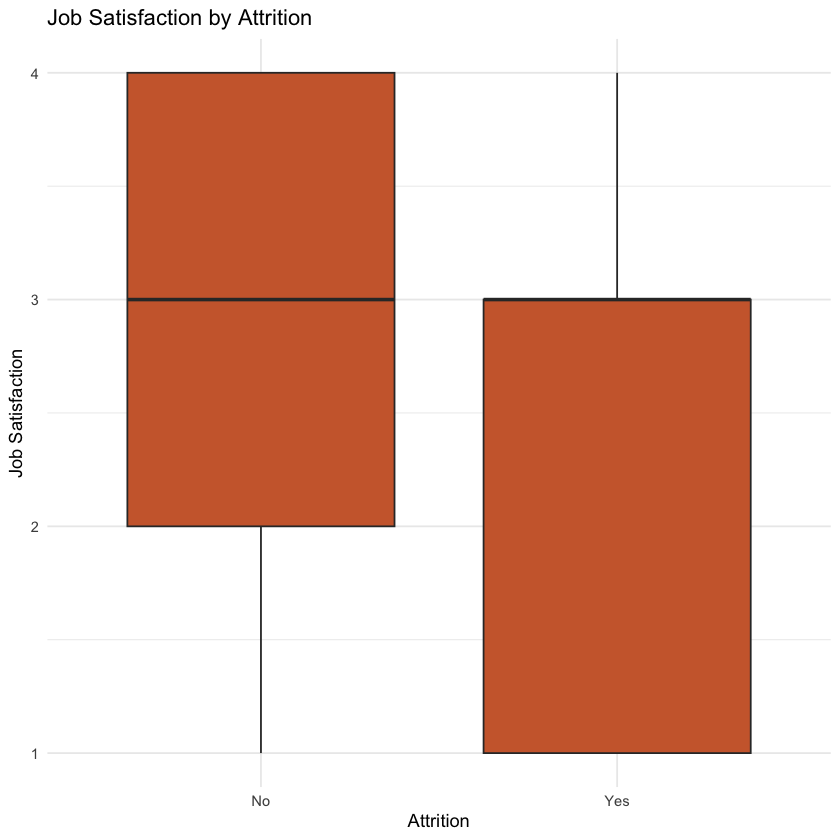

In [19]:
# Job Satisfaction by Attrition
df %>%
    group_by(Attrition) %>%
    ggplot(aes(x = Attrition, y = JobSatisfaction)) +
    geom_boxplot(fill = "sienna3") +
    theme_minimal() +
    labs(
        title = "Job Satisfaction by Attrition",
        x = "Attrition",
        y = "Job Satisfaction"
    )

df %>%
    group_by(Attrition) %>%
    summarize(
        mean_satisfaction = mean(JobSatisfaction),
        median_satisfaction = median(JobSatisfaction),
        sd_satisfaction = sd(JobSatisfaction)
    ) # %>%
    # kable() %>%
    # kable_styling()
    
# Test whether the mean job satisfaction is statistically different between those who left and those who stayed
t.test(
    df %>%
        filter(Attrition == "Yes") %>%
        pull(JobSatisfaction),
    df %>%
        filter(Attrition == "No") %>%
        pull(JobSatisfaction)
)

The mean difference in Job Satisfaction appears small between those who left and those who did not, but further investigation reveals that the difference is strongly statistically significant (p = 0.0015 from a Welch's 2 sample t-test). A visual inspection of the box plot shows evidence of a left skew in job satisfaction for those who left. For these reasons we expect Job Satisfaction to be a strong predictor of attrition.

Next we will look at attrition rate and job satisfaction based on travel:

BusinessTravel,mean_satisfaction,attrition_rate
<chr>,<dbl>,<dbl>
Travel_Frequently,2.905063,0.2215190
Travel_Rarely,2.661812,0.1521036
Non-Travel,2.691489,0.1170213



	Pearson's Chi-squared test

data:  table(df$Attrition, df$BusinessTravel)
X-squared = 5.9945, df = 2, p-value = 0.04993


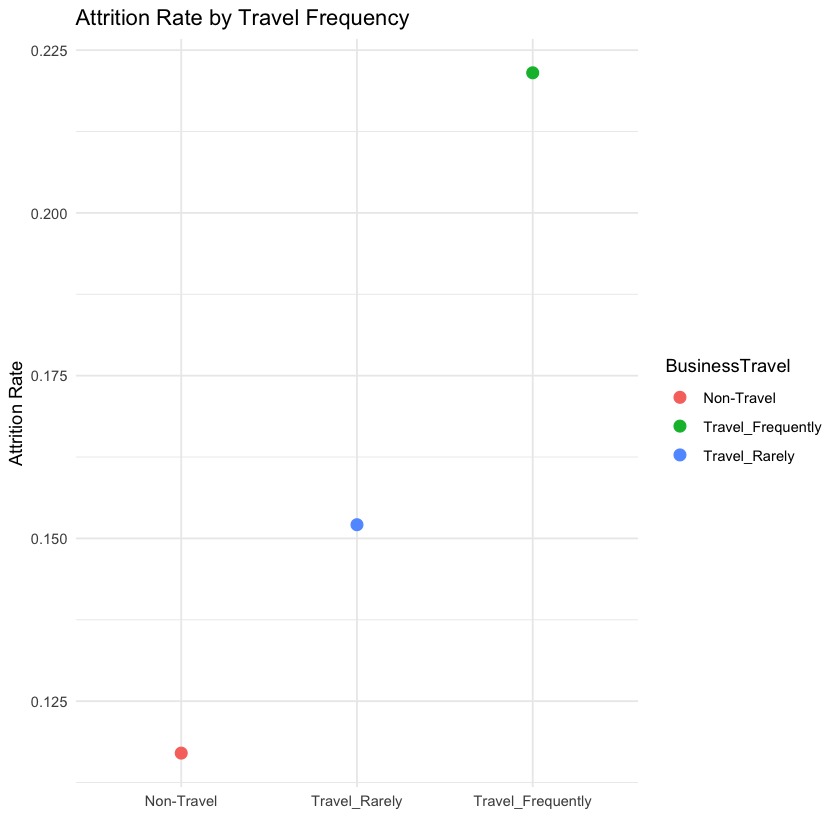

In [20]:
df %>%
    group_by(BusinessTravel) %>%
    summarize(
        mean_satisfaction = mean(JobSatisfaction),
        attrition_rate = mean(Attrition == "Yes")
    ) %>%
    arrange(desc(attrition_rate)) %>%
    ggplot(aes(x = reorder(BusinessTravel, attrition_rate), y = (attrition_rate), color = BusinessTravel)) +
        geom_point(size = 3) +
        theme_minimal() +
        labs(
            title = "Attrition Rate by Travel Frequency",
            x = "",
            y = "Attrition Rate"
        )

df %>%
    group_by(BusinessTravel) %>%
    summarize(
        mean_satisfaction = mean(JobSatisfaction),
        attrition_rate = mean(Attrition == "Yes")
    ) %>%
    arrange(desc(attrition_rate)) # %>% 
    # kable() %>%
    # kable_styling()

# Test whether the attrition rate is statistically different between the three travel categories
chisq.test(table(df$Attrition, df$BusinessTravel))

Here we can see that the attrition rate has a significant association with travel frequency (p = 0.0499 from Pearson's Chi-squared test). Based on this result, we expect travel frequency to be a strong predictor of attrition.

Another factor that could be important in predicting attrition is the performance rating. We do not have data on whether the cases of attrition were voluntary, involuntary, or mutual. One could hypothesize that lower-performing employees are more likely to leave.

Attrition,mean_rating,median_rating,sd_rating
<chr>,<dbl>,<dbl>,<dbl>
No,3.149315,3,0.3566431
Yes,3.164286,3,0.3718651



	Welch Two Sample t-test

data:  df %>% filter(Attrition == "Yes") %>% pull(PerformanceRating) and df %>% filter(Attrition == "No") %>% pull(PerformanceRating)
t = 0.43918, df = 191.23, p-value = 0.661
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05226576  0.08220705
sample estimates:
mean of x mean of y 
 3.164286  3.149315 


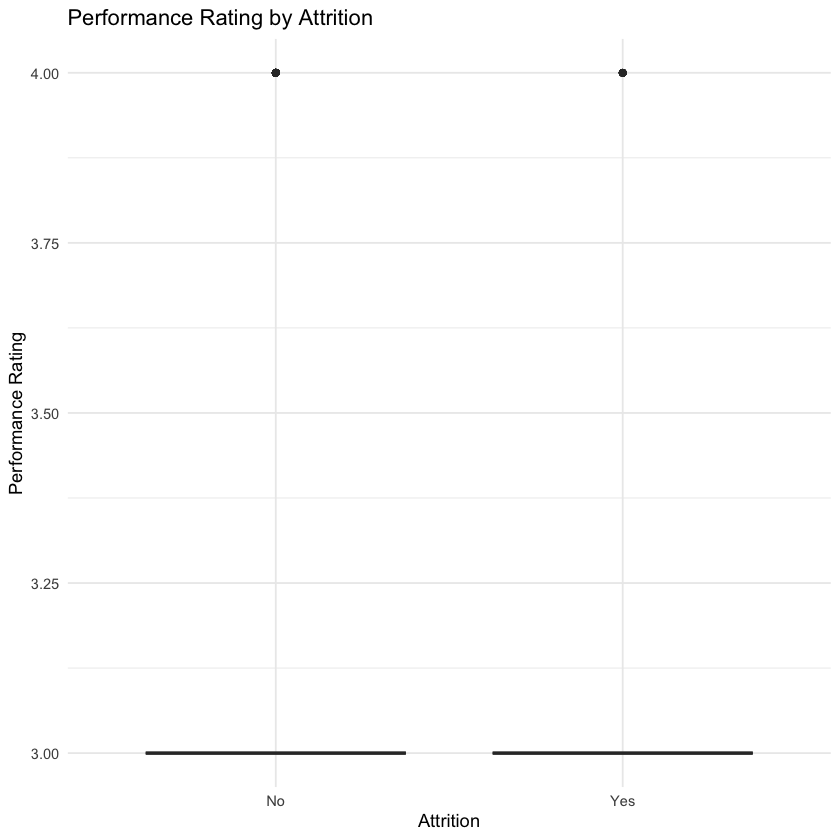

In [21]:
# Boxplots of Performance Rating by Attrition
df %>%
    group_by(Attrition) %>%
    ggplot(aes(x = Attrition, y = PerformanceRating)) +
    geom_boxplot(fill = "sienna3") +
    theme_minimal() +
    labs(
        title = "Performance Rating by Attrition",
        x = "Attrition",
        y = "Performance Rating"
    )

# Summary statistics of Performance Rating by Attrition
df %>%
    group_by(Attrition) %>%
    summarize(
        mean_rating = mean(PerformanceRating),
        median_rating = median(PerformanceRating),
        sd_rating = sd(PerformanceRating)
    ) # %>%
    # kable() %>%
    # kable_styling()
    
# Test whether the mean performance rating is statistically different between those who left and those who stayed
t.test(
    df %>%
        filter(Attrition == "Yes") %>%
        pull(PerformanceRating),
    df %>%
        filter(Attrition == "No") %>%
        pull(PerformanceRating)
)

This is evidently not the case. The performance rating of those who left are nearly identical to those who stayed (p = 0.661 from a two sample t-test). Thus, performance rating is not expected to be a strong predictor of attrition.

### Pairwise scatterplots of key variables

At this point, we will look at pairwise scatterplots between key variables to check for any relationships of multicollinearity that we may have missed. We will also look at the correlation matrix to check for any relationships between variables.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

corrplot 0.92 loaded



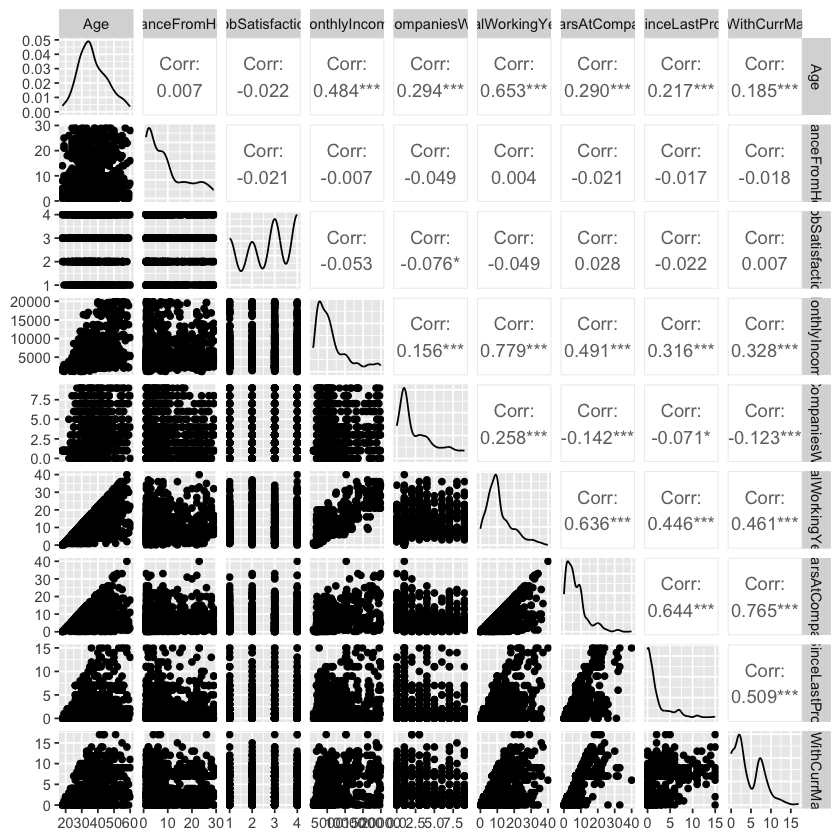

,Age,DistanceFromHome,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.00,0.01,-0.02,0.48,0.29,0.65,0.29,0.22,0.19
DistanceFromHome,0.01,1.00,-0.02,-0.01,-0.05,0.00,-0.02,-0.02,-0.02
JobSatisfaction,-0.02,-0.02,1.00,-0.05,-0.08,-0.05,0.03,-0.02,0.01
MonthlyIncome,0.48,-0.01,-0.05,1.00,0.16,0.78,0.49,0.32,0.33
NumCompaniesWorked,0.29,-0.05,-0.08,0.16,1.00,0.26,-0.14,-0.07,-0.12
TotalWorkingYears,0.65,0.00,-0.05,0.78,0.26,1.00,0.64,0.45,0.46
YearsAtCompany,0.29,-0.02,0.03,0.49,-0.14,0.64,1.00,0.64,0.77
YearsSinceLastPromotion,0.22,-0.02,-0.02,0.32,-0.07,0.45,0.64,1.00,0.51
YearsWithCurrManager,0.19,-0.02,0.01,0.33,-0.12,0.46,0.77,0.51,1.00


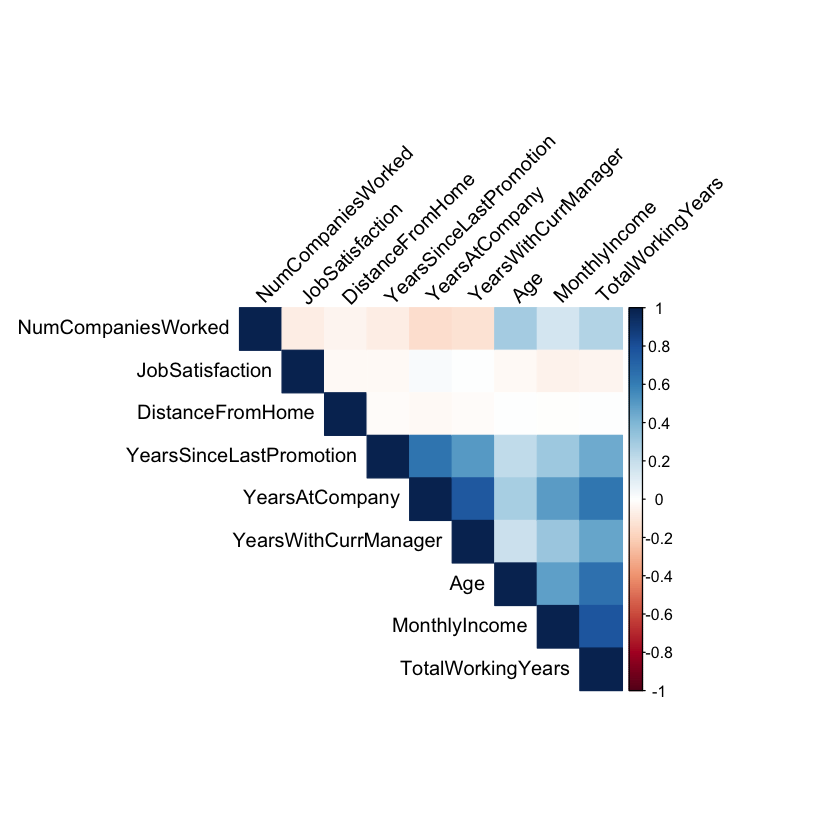

In [22]:
# Pairwise scatterplots of key variables using ggally
library(GGally)
ggpairs(df %>%
    dplyr::select(
        Age,
        DistanceFromHome,
        JobSatisfaction,
        MonthlyIncome,
        NumCompaniesWorked,
        TotalWorkingYears,
        YearsAtCompany,
        YearsSinceLastPromotion,
        YearsWithCurrManager
    ))

# Correlation matrix heatmap plot with
library(corrplot)
corrplot(cor(df %>%
                dplyr::select(
                    Age,
                    DistanceFromHome,
                    JobSatisfaction,
                    MonthlyIncome,
                    NumCompaniesWorked,
                    TotalWorkingYears,
                    YearsAtCompany,
                    YearsSinceLastPromotion,
                    YearsWithCurrManager
                )),
            method = "color",
            type = "upper",
            order = "hclust",
            tl.col = "black",
            tl.srt = 45)

df %>%
    dplyr::select(
        Age,
        DistanceFromHome,
        JobSatisfaction,
        MonthlyIncome,
        NumCompaniesWorked,
        TotalWorkingYears,
        YearsAtCompany,
        YearsSinceLastPromotion,
        YearsWithCurrManager
    ) %>%
    cor() %>%
        round(2) # %>%
        # kable(col.names = c("Age", "Distance From Home", "Job Satisfaction",
        #     "Income", "Companies Worked", "Total Working Years", "Years At Company",
        #     "Years Since Promotion", "Years With Manager")) %>%
        # column_spec(1:9, width = "fit") %>% 
        # kable_styling(full_width = FALSE)

From the pairwise scatterplots and correlation matrix, we can see some variables that are highly correlated with each other. For example, there appear to be relationships between TotalWorkingYears, YearsAtCompany, and YearsWithCurrManager. We will consider removing YearsAtCompany and YearsWithCurrManager from the model to avoid multicollinearity. Monthly Income appears somewhat correlated with YearsAtCompany and Age, which does make sense and will likely be useful in modelling salary.

## Modelling

The next analysis will be to model the attrition rate and build a classifier to predict the attrition of future employees. We expect this will be useful for DDSAnalytics and their clients, not only for it's predictive power, but also for the insights it can provide into the factors that contribute to attrition. We will also model salary, as this is a key factor in employee retention and one of the questions of interest in this analysis.

### Transformations and further cleaning

Before we begin modelling, we will need to transform some of the variables to fit for the analysis. Based on the earlier visualization of salary data, we will consider all salaries on the log scale in order to correct for the skew and to meet the assumptions inherent in the models. Next, we will transform the categorical variables into dummy variables. At this time, we are leaving the remaining variables in the models despite some multicollinearity, as they may contain useful information despite some redundancy.

In [23]:
dfCopy <- df

# Transform salary to log scale
df <- dfCopy %>%
    mutate(
        logMonthlyIncome = log(MonthlyIncome)
    ) %>%
    select(-MonthlyIncome)

# Transform categorical variables to dummy variables using dummyVars
dummy_model <- dummyVars(Attrition ~ ., data = df)
df_dummy <- as.data.frame(predict(dummy_model, newdata = df))
df_dummy$Attrition <- df$Attrition
# df_dummy <- clean_names(df_dummy) # Might be needed to linear regression, uncomment if so

### Attrition

The first aspect of that data we will model is attrition. The plan is to use both a KNN and Naive Bayes classifier to predict attrition. We will use sensitivity and specificity to evaluate the performance of the models and Confusion Matrices to evaluate the results. Our benchmark goal for a useful model is a sensitivity and specificity of at least 60% each.

#### KNN

K-Nearest Neighbors is a non-parametric method used for classification and regression. In this case, we will use it for classification. The algorithm works by assigning a new observation to the class that is most common among its k nearest neighbors. The value of k is a hyperparameter that can be tuned to improve the model. We will use 5-fold cross-validation to tune the model and evaluate the performance of the model. We will also use the caret package to train the model.

Because the dataset is unbalanced in favor of employees who stayed, we will use minority oversampling to balance the dataset. This will help prevent bias in the model in favor of classifying employees as staying, but we will also lose some information by doing this because oversampling effectively duplicates some of the data.

,k,ROC,Sens,Spec,ROCSD,SensSD,SpecSD,metric
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,39,0.7538014,0.7438356,0.6671429,0.03834699,0.04354391,0.07695855,1.410978
2,45,0.7505577,0.7430137,0.6642857,0.04446388,0.05010310,0.07783748,1.407299
3,47,0.7517955,0.7512329,0.6557143,0.04263953,0.03873145,0.09385906,1.406947
4,41,0.7514237,0.7468493,0.6585714,0.04555124,0.04755549,0.07857143,1.405421
5,43,0.7551076,0.7550685,0.6500000,0.03718659,0.03527453,0.07715167,1.405068
6,49,0.7481703,0.7586301,0.6385714,0.04024735,0.03870924,0.07166627,1.397202
7,33,0.7470108,0.7446575,0.6471429,0.03468160,0.05890411,0.06863588,1.391800
8,37,0.7416438,0.7405479,0.6485714,0.04462255,0.04337839,0.07411611,1.389119
9,31,0.7474804,0.7375342,0.6485714,0.03584046,0.04652663,0.06813851,1.386106


Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  550  36
       Yes 180 104
                                          
               Accuracy : 0.7517          
                 95% CI : (0.7216, 0.7801)
    No Information Rate : 0.8391          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3506          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7534          
            Specificity : 0.7429          
         Pos Pred Value : 0.9386          
         Neg Pred Value : 0.3662          
             Prevalence : 0.8391          
         Detection Rate : 0.6322          
   Detection Prevalence : 0.6736          
      Balanced Accuracy : 0.7481          
                                          
       'Positive' Class : No              
                              

Warning message in verify_d(data$d):
“D not labeled 0/1, assuming No = 0 and Yes = 1!”
Warning message in verify_d(data$d):
“D not labeled 0/1, assuming No = 0 and Yes = 1!”


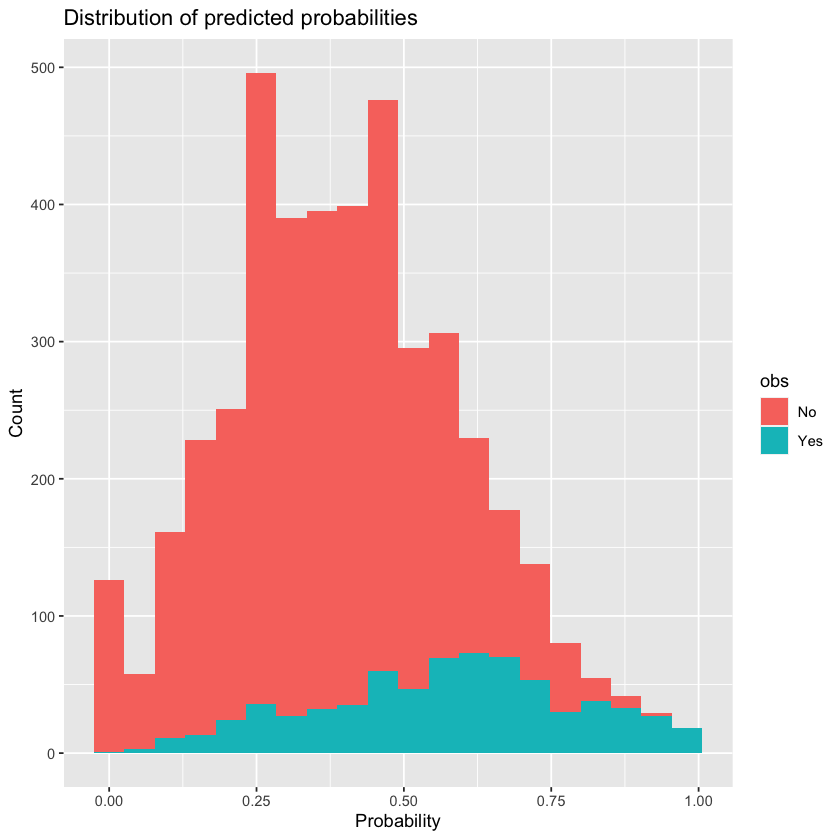

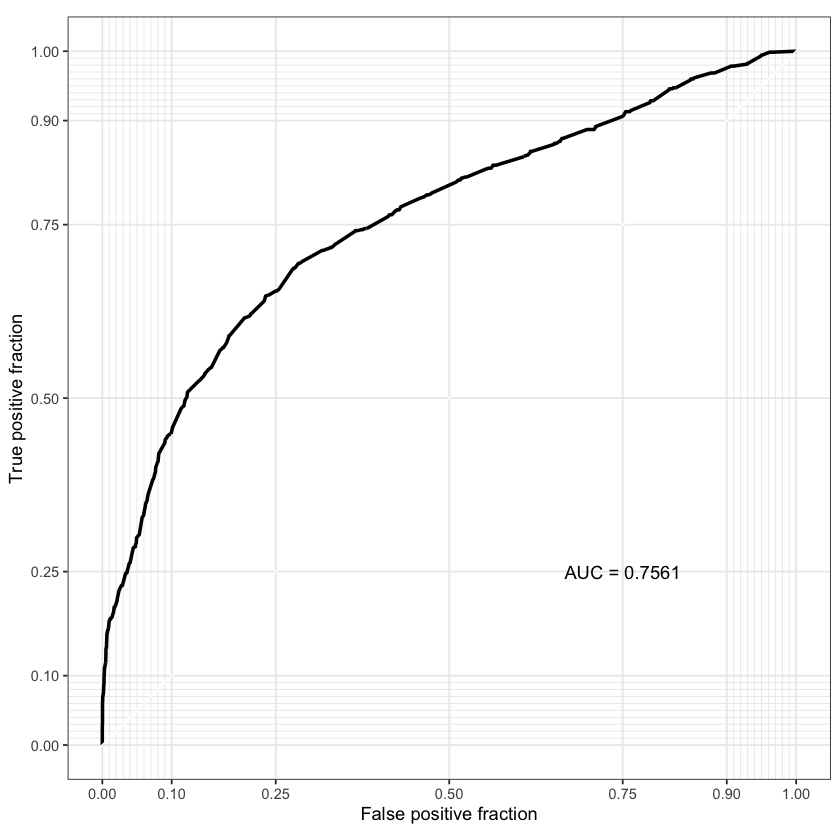

In [24]:
# Train a KNN model using caret

# Define trainControl for 5-fold cross-validation with minority oversampling
ctrl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 5,
    classProbs = TRUE,
    savePredictions = TRUE,
    sampling = "up",
    summaryFunction = twoClassSummary
)

# Define tuning grid for k
tuningGrid <- expand.grid(
    k = seq(5, 49, by = 2)
)

# Check if the model object exists, train if it doesn't
if (file.exists("Models/knn.rds")) {
  # Load the model object from disk
  knn_model <- readRDS("Models/knn.rds")
} else {
  # Perform stepwise selection

  # Set up a parallel backend with the number of cores you want to use
  cores <- 8 # Change this to the number of cores you want to use
  cl <- makePSOCKcluster(cores)
  registerDoParallel(cl)

    # Train the model
    set.seed(137)
    knn_model <- train(Attrition ~ .,
        data = df_dummy,
        method = "knn",
        trControl = ctrl,
        tuneGrid = tuningGrid,
        preProcess = c("center", "scale", "nzv"),
        metric = "ROC",
        tuneLength = 10,
        na.action = na.omit
    )
  
  # Stop the parallel backend
  stopCluster(cl)
  
  # Save the model object to disk
  saveRDS(knn_model, "Models/knn.rds")
}

# Check the best overall results
knn_model$results %>%
    mutate(metric = Sens + Spec) %>%
    arrange(desc(metric)) %>%
    head(10)

# Evaluate the model using confusion matrix
predictions <- predict(knn_model, newdata = df_dummy)
confusion_matrix <- confusionMatrix(predictions, as.factor(df_dummy$Attrition))
confusion_matrix

# Visualize how the results are classified
knn_model$pred %>%
    filter(k == knn_model$bestTune$k) %>%
    select(Yes, obs) %>%
    ggplot(aes(x = Yes, fill = obs)) +
    geom_histogram(bins = 20) +
    labs(x = "Probability", y = "Count", title = "Distribution of predicted probabilities")

# Plot ROC curve
selectedIndices <- knn_model$pred$k == knn_model$bestTune$k
library(plotROC)
g <- ggplot(knn_model$pred[selectedIndices, ], aes(m = Yes, d = factor(obs, levels = c("Yes", "No")))) +
    geom_roc(n.cuts = 0) +
    coord_equal() +
    style_roc()
g <- g + annotate("text", x = 0.75, y = 0.25, label = paste("AUC =", round((calc_auc(g))$AUC, 4)))
g

The KNN model performs fairly well. It's Sensitivity and Specificity are both 0.75 against the whole training set, with a ROC AUC of 0.75 as well. These meet the goals of the project, but the negative predictive value (in this case, Attrition = Yes) is still quite low at 0.37. Oversampling the minority class is crucial for the KNN. Without balancing the classes, accuracy approaches 0.99, but the specificity is only 0.07. In short, the KNN is useful, but we expect the Naive Bayes model to be an improvement given it's probabilistic nature.


#### Naive Bayes

A Naive Bayes model is a probabilistic model that is commonly used for classification tasks. It's based on Bayes' theorem, which states that the probability of a hypothesis (in this case, a classification) given some evidence (in this case, the features or variables) is proportional to the probability of the evidence given the hypothesis, multiplied by the prior probability of the hypothesis. Theorem: $$ P(A|B) = \frac{(P(B|A)P(A))}{P(B)} $$ The Naive Bayes model makes the assumption that the features are independent of each other, which is why it's called "Naive". This assumption is often violated in real-world data, but it's a useful model for classification tasks.

Because Naive Bayes is a probabilistic model, the unbalanced nature of the Attrition data should be less of an issue. Like the KNN, we wil train the model using 5-fold repeated cross-validation using the caret package. We will also use the hyperparameters Laplace smoothing, bandwidth, and kernel to tune the model.

            Length Class              Mode     
data         2     -none-             list     
levels       2     -none-             character
laplace      1     -none-             numeric  
tables      48     naive_bayes_tables list     
prior        2     table              numeric  
usekernel    1     -none-             logical  
usepoisson   1     -none-             logical  
call         6     -none-             call     
xNames      48     -none-             character
problemType  1     -none-             character
tuneValue    3     data.frame         list     
obsLevels    2     -none-             character
param        0     -none-             list     

,usekernel,laplace,adjust,ROC,Sens,Spec,ROCSD,SensSD,SpecSD,metric
,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TRUE,0.2,1.9,0.8071331,0.7493151,0.7357143,0.03866235,0.06783358,0.09505190,1.485029
2,TRUE,0.4,1.7,0.8050391,0.7569863,0.7271429,0.04050860,0.07337404,0.08618423,1.484129
3,TRUE,0.0,1.3,0.8026712,0.7495890,0.7314286,0.03546684,0.06838119,0.09732825,1.481018
4,TRUE,1.0,1.9,0.8046282,0.7465753,0.7328571,0.03902141,0.06016751,0.07859848,1.479432
5,TRUE,0.6,1.7,0.8055186,0.7487671,0.7300000,0.03827467,0.06885521,0.09397224,1.478767
6,TRUE,0.0,1.5,0.8047162,0.7443836,0.7342857,0.03943997,0.04969570,0.09730641,1.478669
7,TRUE,0.6,1.9,0.8049902,0.7569863,0.7200000,0.03838028,0.05991096,0.08849651,1.476986
8,TRUE,0.2,1.5,0.8047945,0.7435616,0.7314286,0.03807871,0.06029991,0.09948849,1.474990
9,TRUE,1.0,1.3,0.8031703,0.7441096,0.7300000,0.03399051,0.06339102,0.09051534,1.474110


Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  556  28
       Yes 174 112
                                          
               Accuracy : 0.7678          
                 95% CI : (0.7383, 0.7955)
    No Information Rate : 0.8391          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3951          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7616          
            Specificity : 0.8000          
         Pos Pred Value : 0.9521          
         Neg Pred Value : 0.3916          
             Prevalence : 0.8391          
         Detection Rate : 0.6391          
   Detection Prevalence : 0.6713          
      Balanced Accuracy : 0.7808          
                                          
       'Positive' Class : No              
                              

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following object is masked from ‘package:plotROC’:

    ggroc


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases



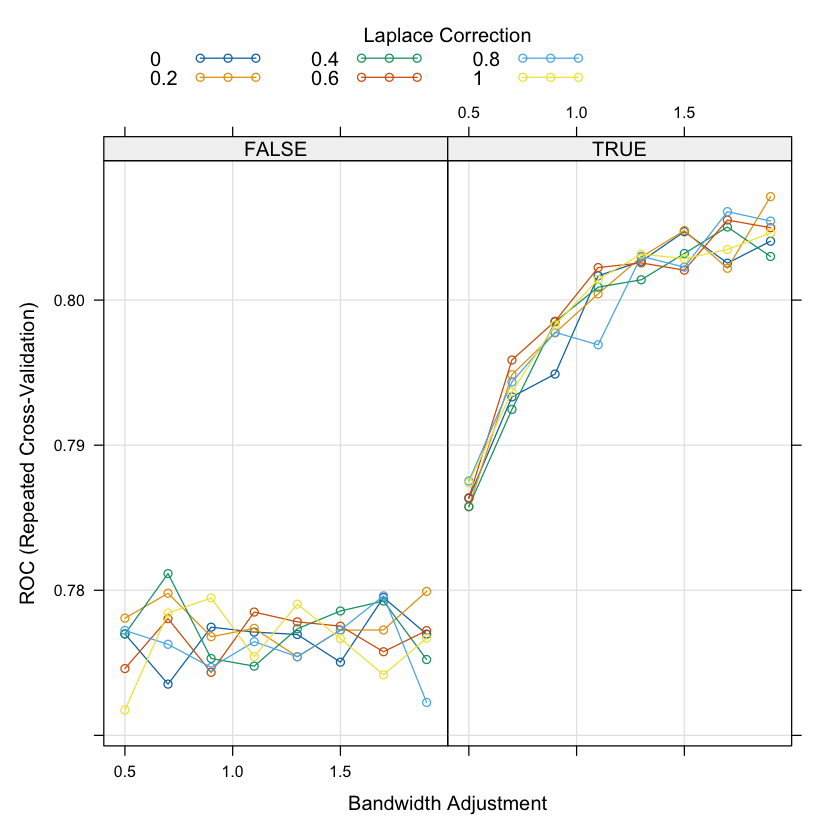

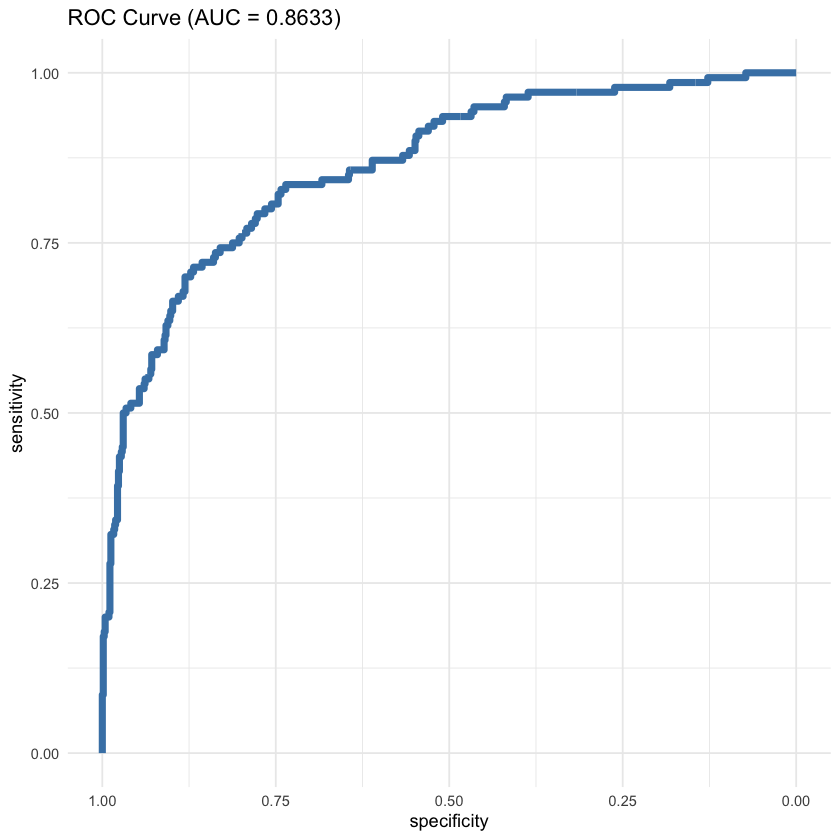

In [25]:
# Train a Naive Bayes model using caret

# Define trainControl for 5-fold cross-validation with minority oversampling
ctrl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 5,
    classProbs = TRUE,
    savePredictions = TRUE,
    sampling = "up",
    summaryFunction = twoClassSummary
)

# Define tuning grid for NB
tuningGrid <-   expand.grid(usekernel = c(TRUE, FALSE),
                         laplace = seq(0,1, by = 0.2), 
                         adjust = seq(0.5, 1.9, by = 0.2))

# Check if the model object exists, train if it doesn't
if (file.exists("Models/nb.rds")) {
  # Load the model object from disk
  nb_model <- readRDS("Models/nb.rds")
} else {
  # Perform stepwise selection

  # Set up a parallel backend with the number of cores you want to use
  cores <- 8 # Change this to the number of cores you want to use
  cl <- makePSOCKcluster(cores)
  registerDoParallel(cl)

  # Train the model
    set.seed(137)
    nb_model <- train(Attrition ~ .,
        data = df_dummy,
        method = "naive_bayes",
        trControl = ctrl,
        tuneGrid = tuningGrid,
        preProcess = c("center", "scale", "nzv"),
        metric = "ROC",
        na.action = na.omit
    )
  
  # Stop the parallel backend
  stopCluster(cl)
  
  # Save the model object to disk
  saveRDS(nb_model, "Models/nb.rds")
}

summary(nb_model)
plot(nb_model)

# Check the best overall results
nb_model$results %>%
    mutate(metric = Sens + Spec) %>%
    arrange(desc(metric)) %>%
    head(10)

# Evaluate the model using confusion matrix
predictions <- predict(nb_model, newdata = df_dummy)
confusion_matrix <- confusionMatrix(predictions, as.factor(df_dummy$Attrition))
confusion_matrix

# Visualize how the results are classified
# as.data.frame(predictions) %>% 
#     ggplot(aes(x = predictions, fill = df_dummy$Attrition)) +
#     geom_histogram(bins = 20) +
#     labs(x = "Probability", y = "Count", title = "Distribution of predicted probabilities")

# Load necessary packages
library(ggplot2)
library(pROC)

# define object to plot and calculate AUC
evalResult.nb <- predict(nb_model, df_dummy, type = "prob")
rocobj <- roc(df_dummy$Attrition, evalResult.nb[, 2])
auc <- round(auc(df_dummy$Attrition, evalResult.nb[, 2]),4)

#create ROC plot with minimal theme
ggroc(rocobj, colour = 'steelblue', size = 2) +
  ggtitle(paste0('ROC Curve ', '(AUC = ', auc, ')')) +
  theme_minimal()

As expected, the Naive Bayes model appears to be an improvement on the KNN model. Compared against the entire training set, the Sensitivity is 0.76 and the Specificity is 0.80 with a ROC AUC of 0.86. The negative predicted value is likewise improved, but still fairly low at 0.39. The model has a Kappa score of 0.395 vs 0.35 for the KNN. Like the KNN, oversampling the minority class is crucial due to the unbalanced nature of the dataset.

The author posits that there may be a reason that these models struggle with predicting Attrition. It may be that there is an upper limit on the accuracy with which Attrition can be predicted given the data we have. The decision to leave (or ask a subordinate to leave) is a complex decision that is influenced by many factors. Perhaps the data we have has some associations with Attrition, but fails to capture the internal factors which influence this decision.

Next we will find the variable importance from the Naive Bayes model.


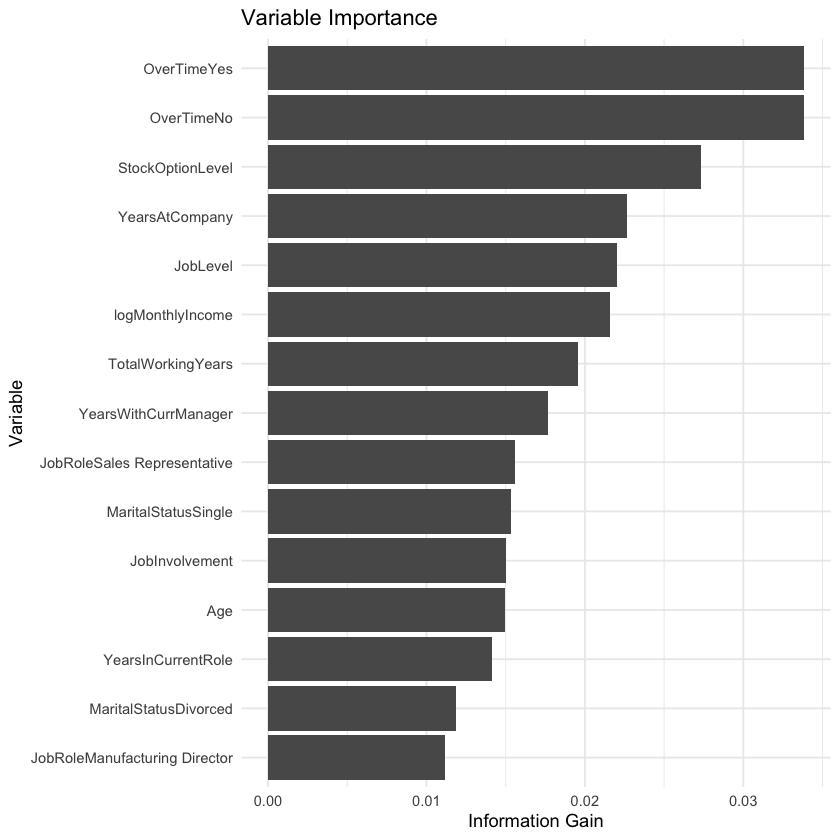

In [26]:
# Install and load the FSelectorRcpp package
# install.packages("FSelectorRcpp")
library(FSelectorRcpp)

# Prepare your dataset by separating the features and the target variable
names <- names(df_dummy)[-which(names(df_dummy) == "Attrition")]
X <- df_dummy[, names]
y <- df_dummy$Attrition

# Calculate information gain
info_gain <- information_gain(X, y)

# Convert the result to a data frame and sort
info_gain_df <- as.data.frame(info_gain) %>%
  rownames_to_column("variable") %>%
  arrange(desc(importance))

# Filter by desired threshold
info_gain_filtered <- info_gain_df %>%
    filter(importance > 0.01)

# Plot the results
ggplot(info_gain_filtered, aes(x = reorder(attributes, importance), y = importance)) +
    geom_bar(stat = "identity") +
    coord_flip() +
    labs(x = "Variable", y = "Information Gain", title = "Variable Importance") +
    theme_minimal()

The most important factors predicting attrition include: Part Time Status, StockOptionLevel, Years at company, Job level, and Monthly Income. All of these make sense intuitively. Part time employees probably are more likely to leave, as are employees with low levels of stock options, low job levels, and low monthly income. This is consistent with the results of our data exploration, which show that a lower attrition is associated with more senior jobs, and higher incomes.

#### Logistic regression

Internal factors aside, we are curious whether another model might be able to improve on the predictive power of the KNN and Naive Bayes model. To test this, we will fit a Boosted Logistic Regression model on the training data and compare its performance. Logistic Regression is outside the scope of this document, but the author notes that it involves making a tradeoff on the interpretability of the model. 

            Length Class      Mode     
Stump       93     -none-     numeric  
lablist      2     factor     numeric  
xNames      49     -none-     character
problemType  1     -none-     character
tuneValue    1     data.frame list     
obsLevels    2     -none-     character
param        0     -none-     list     

,nIter,ROC,Sens,Spec,ROCSD,SensSD,SpecSD,metric
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,31,0.7729843,0.8079452,0.6100000,0.04857663,0.04952865,0.09100721,1.417945
2,11,0.7572358,0.7794521,0.6357143,0.03507321,0.04061746,0.08808719,1.415166
3,21,0.7646135,0.7863014,0.6214286,0.04660641,0.05716888,0.11199338,1.407730


Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  558  15
       Yes 172 125
                                          
               Accuracy : 0.7851          
                 95% CI : (0.7562, 0.8119)
    No Information Rate : 0.8391          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.4523          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7644          
            Specificity : 0.8929          
         Pos Pred Value : 0.9738          
         Neg Pred Value : 0.4209          
             Prevalence : 0.8391          
         Detection Rate : 0.6414          
   Detection Prevalence : 0.6586          
      Balanced Accuracy : 0.8286          
                                          
       'Positive' Class : No              
                              

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases



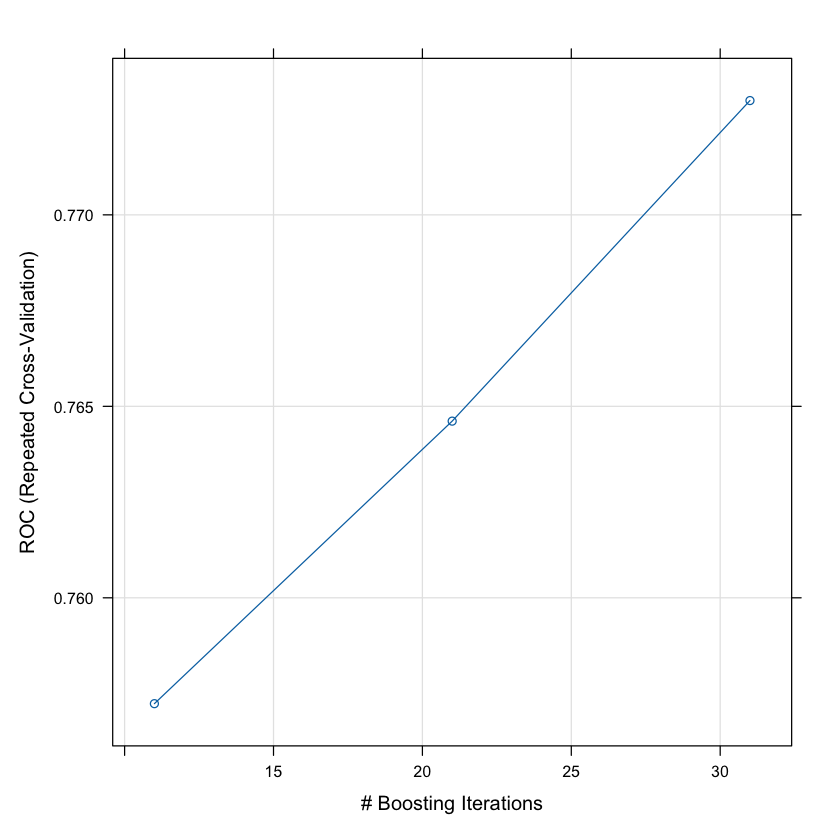

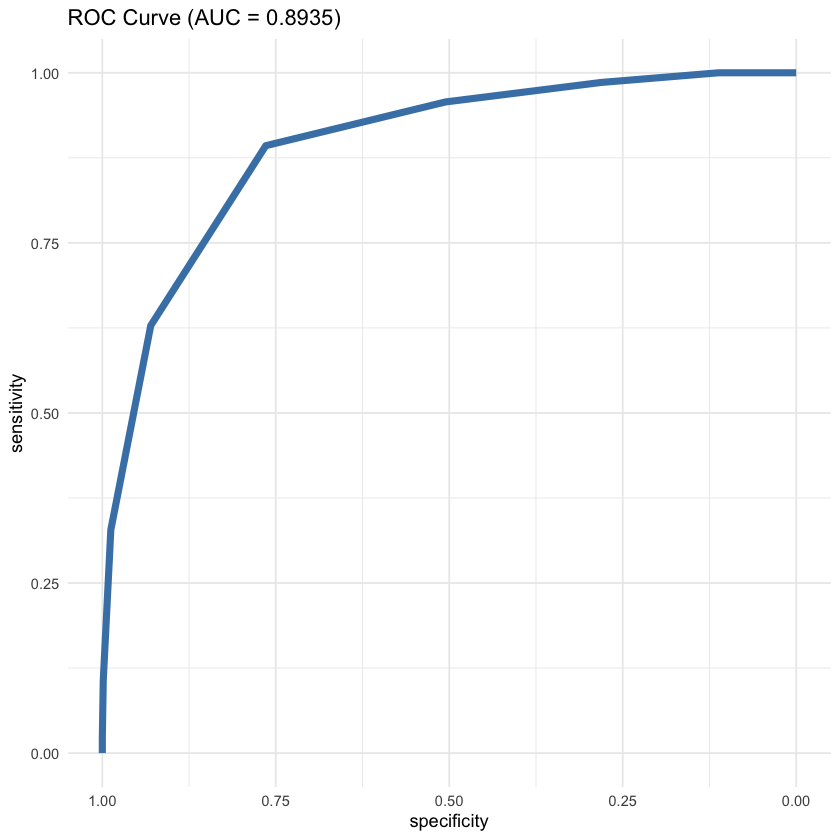

In [27]:
# Train a Logistic Regression model using caret

# Define trainControl for 5-fold cross-validation with minority oversampling
ctrl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 5,
    classProbs = TRUE,
    savePredictions = TRUE,
    sampling = "up",
    summaryFunction = twoClassSummary
)

# Check if the model object exists, train if it doesn't
if (file.exists("Models/lr.rds")) {
  # Load the model object from disk
  lr_model <- readRDS("Models/lr.rds")
} else {
  # Perform stepwise selection

  # Set up a parallel backend with the number of cores you want to use
  cores <- 8 # Change this to the number of cores you want to use
  cl <- makePSOCKcluster(cores)
  registerDoParallel(cl)

  # Train the model
    set.seed(137)
    lr_model <- train(Attrition ~ .,
        data = df_dummy,
        method = "LogitBoost",
        trControl = ctrl,
        # tuneGrid = tuningGrid,
        preProcess = c("center", "scale", "nzv"),
        metric = "ROC",
        na.action = na.omit
    )
  
  # Stop the parallel backend
  stopCluster(cl)
  
  # Save the model object to disk
  saveRDS(lr_model, "Models/lr.rds")
}

summary(lr_model)
plot(lr_model)

# Check the best overall results
lr_model$results %>%
    mutate(metric = Sens + Spec) %>%
    arrange(desc(metric)) %>%
    head(10)

# Evaluate the model using confusion matrix
predictions <- predict(lr_model, newdata = df_dummy)
confusion_matrix <- confusionMatrix(predictions, as.factor(df_dummy$Attrition))
confusion_matrix

# Visualize how the results are classified
# as.data.frame(predictions) %>% 
#     ggplot(aes(x = predictions, fill = df_dummy$Attrition)) +
#     geom_histogram(bins = 20) +
#     labs(x = "Probability", y = "Count", title = "Distribution of predicted probabilities")

# Load necessary packages
library(ggplot2)
library(pROC)

# define object to plot and calculate AUC
evalResult.rf <- predict(lr_model, df_dummy, type = "prob")
rocobj <- roc(df_dummy$Attrition, evalResult.rf[, 2])
auc <- round(auc(df_dummy$Attrition, evalResult.rf[, 2]),4)

#create ROC plot with minimal theme
ggroc(rocobj, colour = 'steelblue', size = 2) +
  ggtitle(paste0('ROC Curve ', '(AUC = ', auc, ')')) +
  theme_minimal()

The Logistic Regression model appears initially to be an improvement on both previous models. Its ROC AUC is 0.89 with Sensitivity 0.76 and Specificity 0.89. The negative predictive value is up to 0.42 and the Kappa score is 0.45. This model will not be used for the submission because it falls outside of the rules.

### Comparing models

Next, we will compare the two models based on their ROC statistic (Area under the ROC curve). The ROC curve is a plot of the true positive rate (Sensitivity) against the false positive rate (1 - Specificity). The area under the ROC curve is a measure of the model's ability to distinguish between the two classes. The closer the area under the curve is to 1, the better the model is at distinguishing between the two classes.


Call:
resamples.default(x = list(KNN = knn_model, NB = nb_model, LR = lr_model))

Models: KNN, NB, LR 
Number of resamples: 25 
Performance metrics: ROC, Sens, Spec 
Time estimates for: everything, final model fit 


Call:
summary.resamples(object = resamps)

Models: KNN, NB, LR 
Number of resamples: 25 

ROC 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
KNN 0.6597358 0.7438845 0.7567270 0.7551076 0.7814335 0.8194716    0
NB  0.7375245 0.7810665 0.8050391 0.8071331 0.8341487 0.8864971    0
LR  0.6740460 0.7365460 0.7833904 0.7729843 0.8122554 0.8511497    0

Sens 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
KNN 0.6917808 0.7260274 0.7602740 0.7550685 0.7671233 0.8150685    0
NB  0.6232877 0.7054795 0.7328767 0.7493151 0.7876712 0.9178082    0
LR  0.6506849 0.7808219 0.8082192 0.8079452 0.8424658 0.8835616    0

Spec 
         Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
KNN 0.4642857 0.6071429 0.6428571 0.6500000 0.6785714 0.8214286    0
NB  0.5357143 0.6428571 0.7500000 0.7357143 0.7857143 0.9285714    0
LR  0.5000000 0.5357143 0.6071429 0.6100000 0.6428571 0.8214286    0


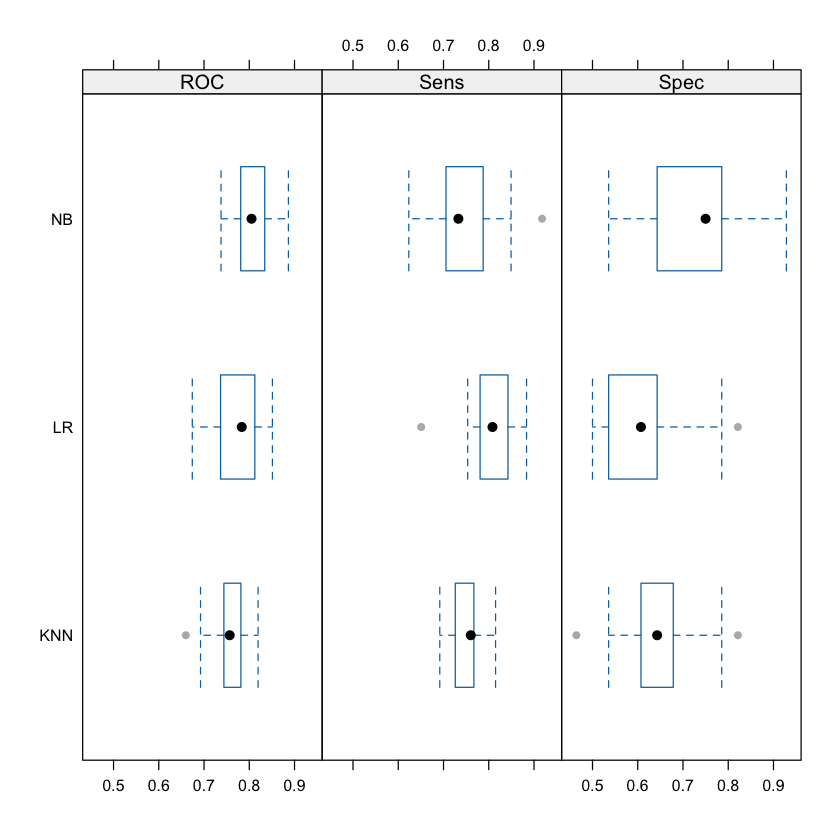


Call:
diff.resamples(x = resamps)

Models: KNN, NB, LR 
Metrics: ROC, Sens, Spec 
Number of differences: 3 
p-value adjustment: bonferroni 


Call:
summary.diff.resamples(object = difValues)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

ROC 
    KNN       NB       LR      
KNN           -0.05203 -0.01788
NB  2.288e-06           0.03415
LR  0.185113  0.007224         

Sens 
    KNN     NB        LR       
KNN          0.005753 -0.052877
NB  1.00000           -0.058630
LR  0.00206 0.00649            

Spec 
    KNN      NB       LR      
KNN          -0.08571  0.04000
NB  0.002348           0.12571
LR  0.325165 3.35e-06         


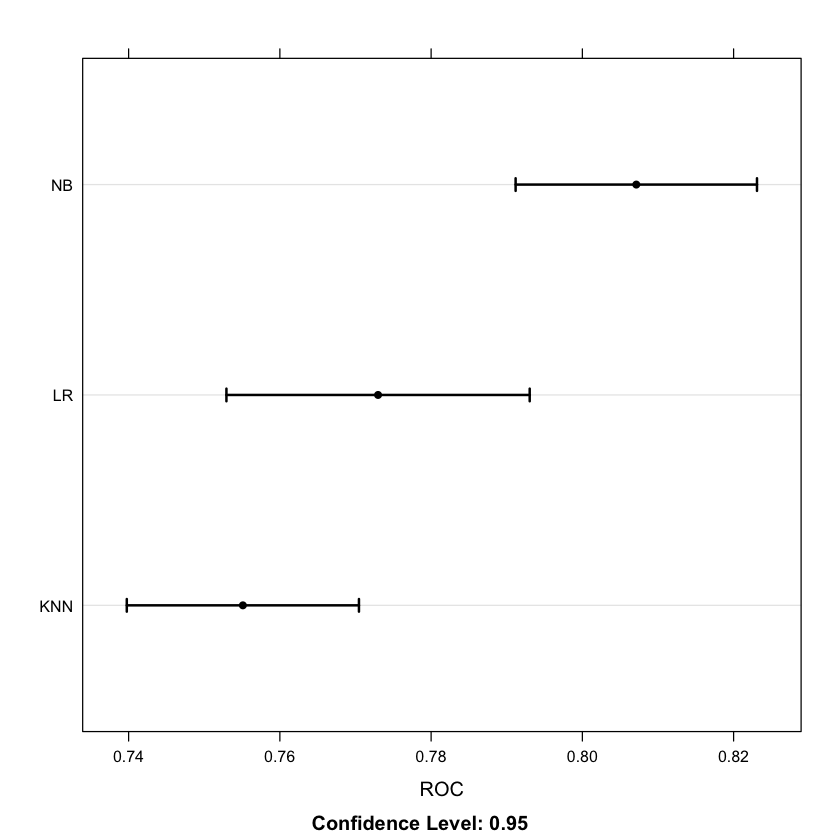

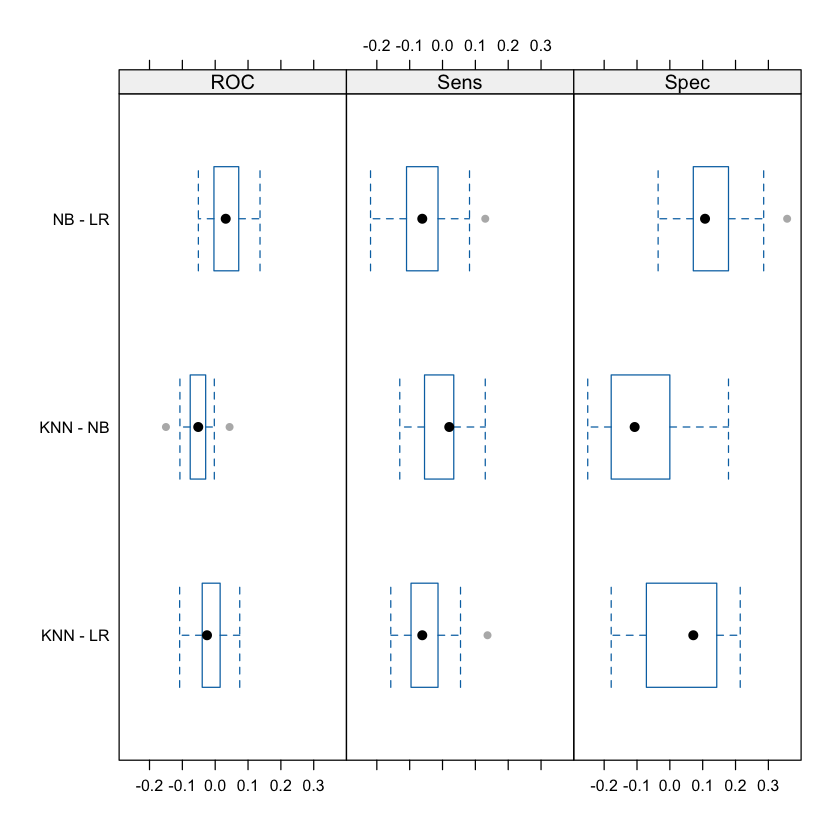

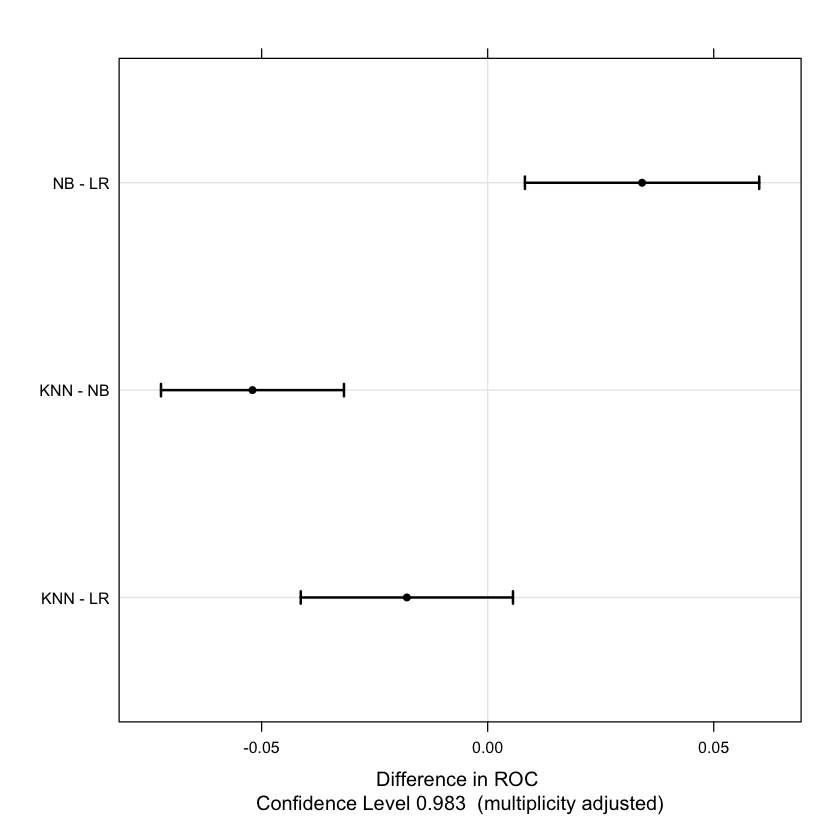

In [28]:
resamps <- resamples(list(
    KNN = knn_model,
    NB = nb_model,
    LR = lr_model
))
resamps
summary(resamps)

theme1 <- trellis.par.get()
theme1$plot.symbol$col = rgb(.2, .2, .2, .4)
theme1$plot.symbol$pch = 16
theme1$plot.line$col = rgb(1, 0, 0, .7)
theme1$plot.line$lwd <- 2
trellis.par.set(theme1)
bwplot(resamps, layout = c(3, 1))

trellis.par.set(caretTheme())
dotplot(resamps, metric = "ROC")

difValues <- diff(resamps)
difValues
summary(difValues)

trellis.par.set(theme1)
bwplot(difValues, layout = c(3, 1))

trellis.par.set(caretTheme())
dotplot(difValues)

From the comparison, we can see that the Naive Bayes model outperforms the KNN on all three metrics. We are primarily concerned with the ROC statistic, which is a good proxy for the Sensitivity plus Specificity standard specified by the project. The Naive Bayes model has a ROC of 0.86, which is a significant improvement over the KNN model's ROC of 0.76. This difference is statistically significant (p-value < 0.001), as is the difference in Specificity (p-value < 0.01). For these reasons, we will use the Naive Bayes model to make Attrition predictions on the test data.

The performance between the Naive Bayes and Logistic Regression is more Nuanced. The Logistic Regression had high ROC and summary statistics across the whole dataset, but the Naive Bayes outperforms it on average across the cross-validation resamples. In fact, the Naive Bayes model has significantly better ROC (p < 0.01).


Next, we will write the predictions using the Naive Bayes model on the test data to a csv file for submission to DDSAnalytics.

In [29]:
# Make predictions on the test data using the classification model
test <- read_csv("Test/CaseStudy2CompSet No Attrition.csv", show_col_types = FALSE)
testCopy <- test

# Transform salary to log scale
test <- testCopy %>%
    mutate(
        logMonthlyIncome = log(MonthlyIncome)
    ) %>%
    select(-MonthlyIncome)

# Remove columns with only one unique value
test = test %>%
    select(-c(Over18, StandardHours, EmployeeCount))

# Transform categorical variables to dummy variables using dummyVars
dummy_model <- dummyVars(~ ., data = test)
test_dummy <- as.data.frame(predict(dummy_model, newdata = test))
# test_dummy <- clean_names(test_dummy) # Might be needed to linear regression, uncomment if so

# Make predictions on the test data using the knn model
predictions <- predict(nb_model, newdata = test_dummy)
predictions <- as.data.frame(predictions) %>%
    cbind(ID = test$ID) %>%
    mutate(Attrition = predictions) %>% 
    select(ID, Attrition)

# Write predictions to csv file
write_csv(predictions, "Predictions/Case2PredictionsSager Attrition.csv")

### Salary

The second aspect of that data we will model is Salary in the form of Monthly Income. We will use a Linear Regression to predict salary from the training data. For this model, we will use the Root Mean Squared Error (RMSE) to evaluate our models. Our benchmark goal for a useful model is a RMSE of less than $3000, but we expect to be able to do much better than that.

#### Linear Regression

We will need to transform the data slightly differently to model salary. The Monthly Income column will be transformed to the log scale, and Attrition will be left in the dataset and transformed to a dummy variable. 


In [30]:
# Transform salary to log scale
df <- dfCopy %>%
    mutate(
        logMonthlyIncome = log(MonthlyIncome)
    ) %>%
    select(-MonthlyIncome, -EmployeeNumber)

# Transform categorical variables to dummy variables using dummyVars
dummy_model <- dummyVars(logMonthlyIncome ~ ., data = df)
df_dummy <- as.data.frame(predict(dummy_model, newdata = df))
df_dummy$logMonthlyIncome <- df$logMonthlyIncome
df_dummy <- clean_names(df_dummy) # Might be needed to linear regression, uncomment if so

Next, we will train the linear model with stepwise feature selection.

In [31]:
# Stepwise Selection
ctrl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 5,
    # classProbs = TRUE,
    savePredictions = TRUE
    # sampling = "up",
    # summaryFunction = twoClassSummary
)

# Check if the model object exists, train if it doesn't
if (file.exists("Models/lm.rds")) {
  # Load the model object from disk
  lm_fit <- readRDS("Models/lm.rds")
} else {
  # Perform stepwise selection

  # Set up a parallel backend with the number of cores you want to use
  cores <- 8 # Change this to the number of cores you want to use
  cl <- makePSOCKcluster(cores)
  registerDoParallel(cl)

  set.seed(137)
  lm_fit <- train(log_monthly_income ~ .,
    data = df_dummy,
    trControl = ctrl,
    method = "glmStepAIC",
    direction = "both",
    preProcess = c("center", "scale", "nzv", "BoxCox")
  )
  
  # Stop the parallel backend
  stopCluster(cl)
  
  # Save the model object to disk
  saveRDS(lm_fit, "Models/lm.rds")
}

summary(lm_fit)
defaultSummary(data.frame(pred = predict(lm_fit, df_dummy), obs = df_dummy$log_monthly_income))
varImp(lm_fit, scale = TRUE)


Call:
NULL

Coefficients:
                                    Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                         8.537680   0.007440 1147.479  < 2e-16 ***
business_travel_non_travel         -0.026259   0.007496   -3.503 0.000483 ***
daily_rate                          0.012478   0.007494    1.665 0.096254 .  
department_sales                   -0.033181   0.013991   -2.372 0.017931 *  
environment_satisfaction           -0.010949   0.007508   -1.458 0.145121    
job_level                           0.399697   0.018225   21.931  < 2e-16 ***
job_role_healthcare_representative  0.048075   0.010685    4.499 7.76e-06 ***
job_role_laboratory_technician     -0.020188   0.008929   -2.261 0.024023 *  
job_role_manager                    0.134045   0.012361   10.845  < 2e-16 ***
job_role_manufacturing_director     0.054222   0.011131    4.871 1.32e-06 ***
job_role_research_director          0.130103   0.011613   11.203  < 2e-16 ***
job_role_sales_executive            0

RMSE  Rsquared       MAE 
0.2174323 0.8918439 0.1637779

loess r-squared variable importance

  only 20 most important variables shown (out of 53)

                                   Overall
job_level                          100.000
total_working_years                 65.205
years_at_company                    29.167
age                                 26.350
job_role_manager                    24.318
job_role_research_director          20.632
years_in_current_role               19.917
job_role_research_scientist         17.534
years_with_curr_manager             16.919
job_role_laboratory_technician      15.804
years_since_last_promotion          12.033
job_role_sales_representative        8.629
job_role_sales_executive             4.916
attrition_no                         4.636
attrition_yes                        4.636
job_role_manufacturing_director      3.154
num_companies_worked                 2.964
job_role_healthcare_representative   2.715
education                            2.508
job_role_human_resources             2.471

Using stepwise feature selection, the linear model chose 15 parameters. This model achieves a RMSE of 0.21 (log salary data), R squared of 0.89, and a MAE of 0.16. This model exceeds expectations and will be a useful model for predicting salary. The most important variables relate primarily to Job level and time working in the form of total working years and years at the current company. This is unsurprising given the initial analysis, and makes sense intuitively. People generally get promoted over time and are paid more with more experience. It would be interesting to see which factors are the most important when controlling for time. The next most important variables are related to specific positions, as we have seen in the initial analysis.

### Checking Assumptions

To check the assumptions of the linear regression model, we will visualize the residuals with plots to check for linearity and heteroscedasticity. Next, we will plot a histogram of the residuals and Normal Q-Q plot to check for normality.

#### Residual Plots

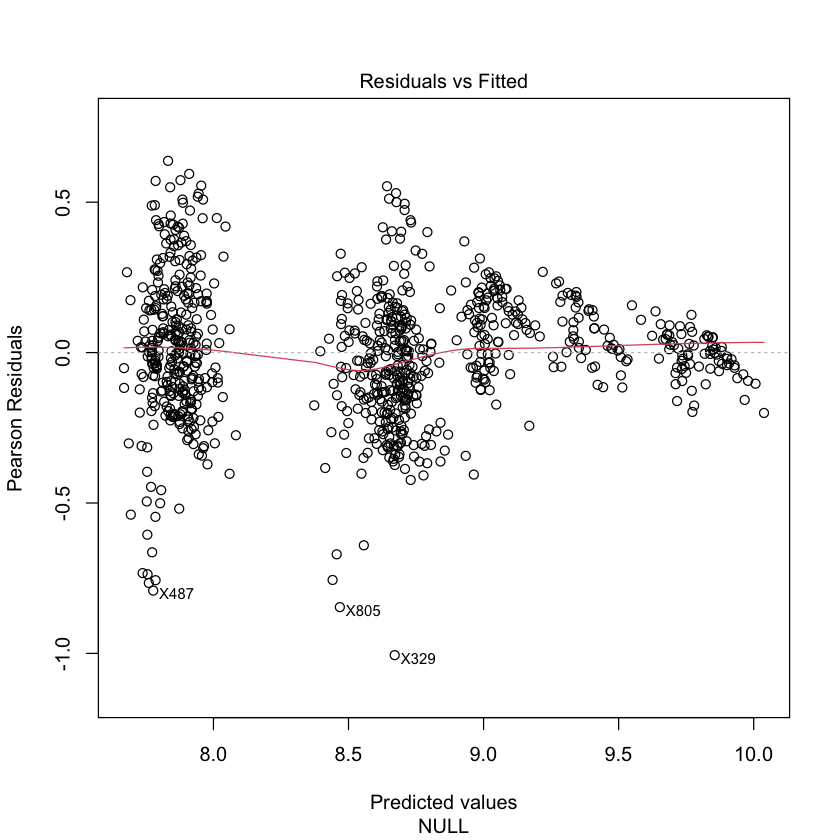

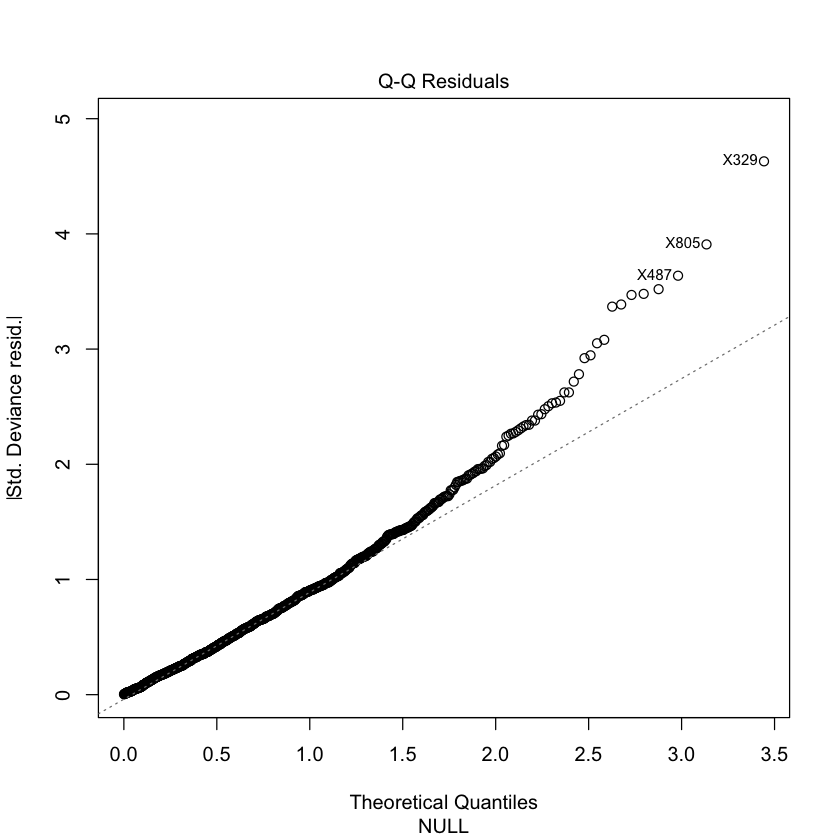

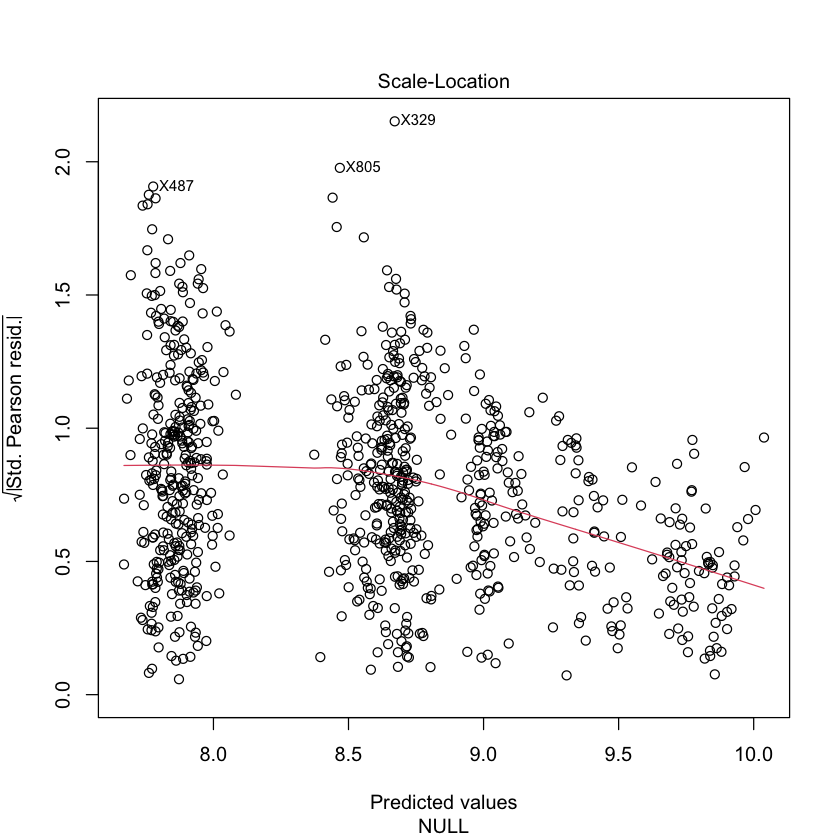

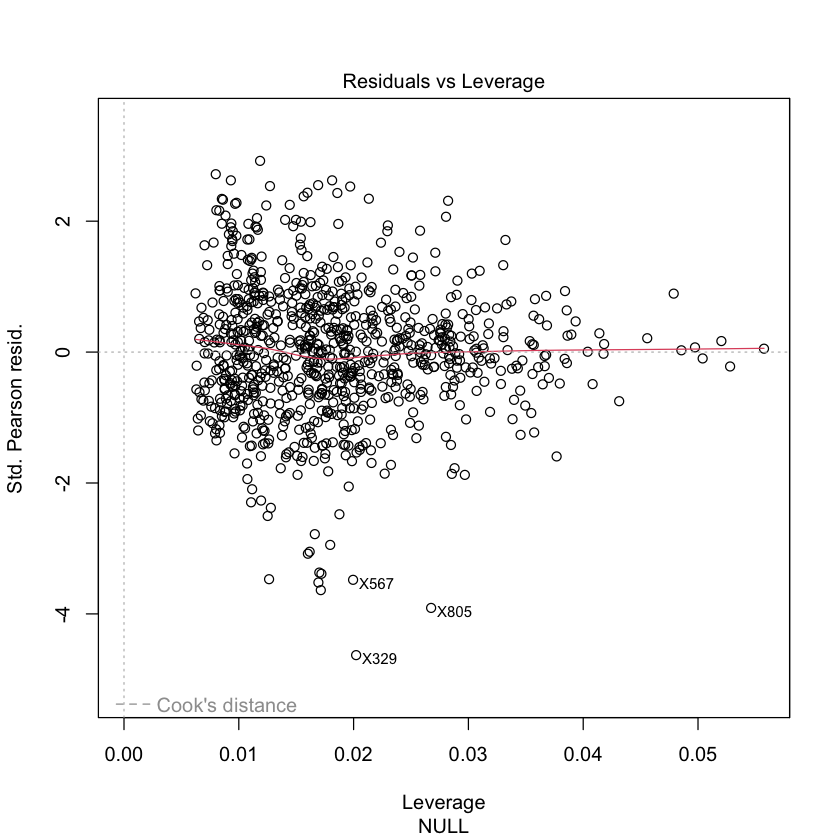

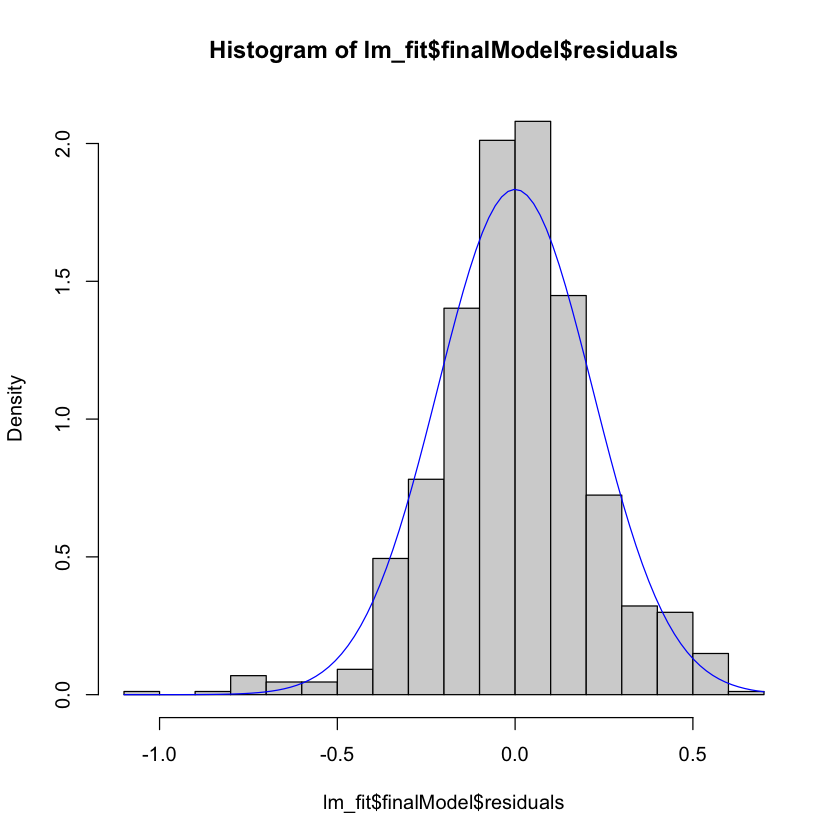

In [32]:
# Plot the residuals using base R
lm_fit$finalModel %>%
  plot()

hist(lm_fit$finalModel$residuals, freq = FALSE, breaks = 12)
curve(
    dnorm(x,
        mean = mean(lm_fit$finalModel$residuals),
        sd = sd(lm_fit$finalModel$residuals)
    ),
    add = TRUE, col = "blue"
)

Based on the plots, the residuals are consistent with a Normal Distribution. There is, however, some visual evidence of heteroscedasticity and non-linearity, especially toward the higher end of predicted salaries. For now, we will proceed with the model as is, but recommend caution using the model for salary predictions above ~$13,000 per month. The author recommends addressing this discrepancy at the higher end by applying other transformations to the monthly income, or using another model such as a random forest.

Lastly, we will write the predictions to a csv file for submission to DDSAnalytics.

In [33]:
# Make predictions on the test data using the regression model
test <- read_csv("Test/CaseStudy2CompSet No Salary.csv", show_col_types = FALSE)
testCopy <- test

# Transform salary to log scale
# test <- testCopy %>%
#     mutate(
#         logMonthlyIncome = log(MonthlyIncome)
#     ) %>%
#     select(-MonthlyIncome)

# Remove columns with only one unique value
test <- test %>%
    select(-c(Over18, StandardHours, EmployeeCount, EmployeeNumber))

# Transform categorical variables to dummy variables using dummyVars
dummy_model <- dummyVars(~ ., data = test)
test_dummy <- as.data.frame(predict(dummy_model, newdata = test))
test_dummy <- clean_names(test_dummy) # Might be needed to linear regression, uncomment if so

# Make predictions on the test data using the knn model
predictions <- predict(lm_fit, newdata = test_dummy)
predictions <- as.data.frame(predictions) %>%
    cbind(ID = test$ID) %>%
    mutate(MonthlyIncome = exp(predictions)) %>% 
    select(ID, MonthlyIncome)

# Write predictions to csv file
write_csv(predictions, "Predictions/Case2PredictionsSager Salary.csv")

## Results and Discussion

The first question DDSAnalytics set out to answer was the top predictors of Attrition. Our analyis concludes that the mose important factors are: part time status, stock option level, and years at the company. Significant factors outside of the top three include job level and salary. Additionally, we found that, given the data, the Naive Bayes model can do a reasonable job of predicting Attrition. These findings and the associated model may be useful in predicting attrition and devising measures to increase retention in the future. As noted in the analysis, the decision to leave a company probably depends on a number of internal and external factors not represented in this data. For this reason, we suspect that there may be an upper limit to the predictive power of these models. Additionally, some of the factors we predicted to be important turned out to be less so in the models. We believe this to be because of the multicollinearity between some of the variables. For example, the model may have chosen to use total working years instead of years at the company because the two variables are highly correlated. This is a limitation of the model, and the author recommends that future models be built to include the variables the researchers are most interested in.

Another question DDSAnalytics set out to answer was what factors influence the salary of an employee. Our analysis concludes that the most important factors are: job level, total working years, and years at the company. The specific role also plays a major role in determining salary levels. The linear regression model we developed can be used to predict salary, and may be useful in determining salary levels for new employees. The model does have some limitations, however. The model does not perform well for salaries above $13,000 per month, but with so few employees at that level, it becomes more difficult to model. The author recommends other methods be used in conjunction with the model for evaluating compensation at that level.

During the course of the analysis, we also discovered many interesting trends when exploring the data. Many of thes could be use in the future to build more specific models or to develop targeted interventions to improve employee retention and satisfaction.

## Conclusion

This analysis has answered the initial questions posed by DDSAnalytics's request, and has perhaps raised even more. The author hopes that this analysis will be useful to DDSAnalytics in their future talent management and efforts to increase retention. Any questions about this analysis or proposals for additional research can be directed to the author at:

Nicholas Sager: nsager@smu.edu  